# Linearly decoded VAE

This notebook shows how to use the 'linearly decoded VAE' model which explicitly links latent variables of cells to genes.

The scVI model learns low-dimensional latent representations of cells which get mapped to parameters of probability distributions which can generate counts consistent to what is observed from data. In the standard version of scVI these parameters for each gene and cell arise from applying neural networks to the latent variables. Neural networks are flexible and can represent non-linearities in the data. This comes at a price, there is no direct link between a latent variable dimension and any potential set of genes which would covary across it.

The `LDVAE` model replaces the neural networks with linear functions. Now a higher value along a latent dimension will directly correspond to higher expression of the genes with high weights assigned to that dimension.

This leads to a generative model comparable to probabilistic PCA or factor analysis, but generates counts rather than real numbers. Using the framework of scVI also allows variational inference which scales to very large datasets and can make use of GPUs for additional speed.

This notebook demonstrates how to fit an `LDVAE` model to scRNA-seq data, plot the latent variables, and interpret which genes are linked to latent variables.

As an example, we use the PBMC 10K from 10x Genomics.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/env/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import seaborn as sns
import torch

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Initialization

Load data and select the top 1000 variable genes with seurat_v3 method

In [5]:
adata_path = os.path.join(save_dir.name, "pbmc_10k_protein_v3.h5ad")
adata = sc.read(
    adata_path,
    backup_url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true",
)

adata

  0%|          | 0.00/23.8M [00:00<?, ?B/s]

/env/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 6855 × 16727
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'encode', 'hvg_encode'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [6]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", layer="counts", n_top_genes=1000, subset=True
)

## Create and fit `LDVAE` model

First subsample 1,000 genes from the original data.

Then we initialize an `LinearSCVI` model. Here we set the latent space to have 10 dimensions.

In [7]:
scvi.model.LinearSCVI.setup_anndata(adata, layer="counts")
model = scvi.model.LinearSCVI(adata, n_latent=10)

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



In [8]:
model.train(max_epochs=250, plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Training:   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 1/250:   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 1/250:   0%|          | 1/250 [00:00<03:18,  1.26it/s]


Epoch 1/250:   0%|          | 1/250 [00:00<03:18,  1.26it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.72e+3]


Epoch 2/250:   0%|          | 1/250 [00:00<03:18,  1.26it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.72e+3]


Epoch 2/250:   1%|          | 2/250 [00:01<01:57,  2.11it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.72e+3]


Epoch 2/250:   1%|          | 2/250 [00:01<01:57,  2.11it/s, v_num=1, train_loss_step=914, train_loss_epoch=811]        


Epoch 3/250:   1%|          | 2/250 [00:01<01:57,  2.11it/s, v_num=1, train_loss_step=914, train_loss_epoch=811]


Epoch 3/250:   1%|          | 3/250 [00:01<01:31,  2.69it/s, v_num=1, train_loss_step=914, train_loss_epoch=811]


Epoch 3/250:   1%|          | 3/250 [00:01<01:31,  2.69it/s, v_num=1, train_loss_step=696, train_loss_epoch=716]


Epoch 4/250:   1%|          | 3/250 [00:01<01:31,  2.69it/s, v_num=1, train_loss_step=696, train_loss_epoch=716]


Epoch 4/250:   2%|▏         | 4/250 [00:01<01:19,  3.10it/s, v_num=1, train_loss_step=696, train_loss_epoch=716]


Epoch 4/250:   2%|▏         | 4/250 [00:01<01:19,  3.10it/s, v_num=1, train_loss_step=868, train_loss_epoch=649]


Epoch 5/250:   2%|▏         | 4/250 [00:01<01:19,  3.10it/s, v_num=1, train_loss_step=868, train_loss_epoch=649]


Epoch 5/250:   2%|▏         | 5/250 [00:01<01:12,  3.36it/s, v_num=1, train_loss_step=868, train_loss_epoch=649]


Epoch 5/250:   2%|▏         | 5/250 [00:01<01:12,  3.36it/s, v_num=1, train_loss_step=560, train_loss_epoch=601]


Epoch 6/250:   2%|▏         | 5/250 [00:01<01:12,  3.36it/s, v_num=1, train_loss_step=560, train_loss_epoch=601]


Epoch 6/250:   2%|▏         | 6/250 [00:02<01:08,  3.55it/s, v_num=1, train_loss_step=560, train_loss_epoch=601]


Epoch 6/250:   2%|▏         | 6/250 [00:02<01:08,  3.55it/s, v_num=1, train_loss_step=790, train_loss_epoch=566]


Epoch 7/250:   2%|▏         | 6/250 [00:02<01:08,  3.55it/s, v_num=1, train_loss_step=790, train_loss_epoch=566]


Epoch 7/250:   3%|▎         | 7/250 [00:02<01:05,  3.69it/s, v_num=1, train_loss_step=790, train_loss_epoch=566]


Epoch 7/250:   3%|▎         | 7/250 [00:02<01:05,  3.69it/s, v_num=1, train_loss_step=561, train_loss_epoch=537]


Epoch 8/250:   3%|▎         | 7/250 [00:02<01:05,  3.69it/s, v_num=1, train_loss_step=561, train_loss_epoch=537]


Epoch 8/250:   3%|▎         | 8/250 [00:02<01:03,  3.79it/s, v_num=1, train_loss_step=561, train_loss_epoch=537]


Epoch 8/250:   3%|▎         | 8/250 [00:02<01:03,  3.79it/s, v_num=1, train_loss_step=506, train_loss_epoch=514]


Epoch 9/250:   3%|▎         | 8/250 [00:02<01:03,  3.79it/s, v_num=1, train_loss_step=506, train_loss_epoch=514]


Epoch 9/250:   4%|▎         | 9/250 [00:02<01:02,  3.86it/s, v_num=1, train_loss_step=506, train_loss_epoch=514]


Epoch 9/250:   4%|▎         | 9/250 [00:02<01:02,  3.86it/s, v_num=1, train_loss_step=485, train_loss_epoch=504]


Epoch 10/250:   4%|▎         | 9/250 [00:02<01:02,  3.86it/s, v_num=1, train_loss_step=485, train_loss_epoch=504]


Epoch 10/250:   4%|▍         | 10/250 [00:03<01:03,  3.75it/s, v_num=1, train_loss_step=485, train_loss_epoch=504]


Epoch 10/250:   4%|▍         | 10/250 [00:03<01:03,  3.75it/s, v_num=1, train_loss_step=409, train_loss_epoch=488]


Epoch 11/250:   4%|▍         | 10/250 [00:03<01:03,  3.75it/s, v_num=1, train_loss_step=409, train_loss_epoch=488]

/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Epoch 11/250:   4%|▍         | 11/250 [00:03<01:03,  3.78it/s, v_num=1, train_loss_step=409, train_loss_epoch=488]


Epoch 11/250:   4%|▍         | 11/250 [00:03<01:03,  3.78it/s, v_num=1, train_loss_step=451, train_loss_epoch=474]


Epoch 12/250:   4%|▍         | 11/250 [00:03<01:03,  3.78it/s, v_num=1, train_loss_step=451, train_loss_epoch=474]


Epoch 12/250:   5%|▍         | 12/250 [00:03<01:02,  3.80it/s, v_num=1, train_loss_step=451, train_loss_epoch=474]


Epoch 12/250:   5%|▍         | 12/250 [00:03<01:02,  3.80it/s, v_num=1, train_loss_step=479, train_loss_epoch=468]


Epoch 13/250:   5%|▍         | 12/250 [00:03<01:02,  3.80it/s, v_num=1, train_loss_step=479, train_loss_epoch=468]


Epoch 13/250:   5%|▌         | 13/250 [00:03<01:02,  3.80it/s, v_num=1, train_loss_step=479, train_loss_epoch=468]


Epoch 13/250:   5%|▌         | 13/250 [00:03<01:02,  3.80it/s, v_num=1, train_loss_step=502, train_loss_epoch=456]


Epoch 14/250:   5%|▌         | 13/250 [00:03<01:02,  3.80it/s, v_num=1, train_loss_step=502, train_loss_epoch=456]


Epoch 14/250:   6%|▌         | 14/250 [00:04<01:01,  3.82it/s, v_num=1, train_loss_step=502, train_loss_epoch=456]


Epoch 14/250:   6%|▌         | 14/250 [00:04<01:01,  3.82it/s, v_num=1, train_loss_step=416, train_loss_epoch=453]


Epoch 15/250:   6%|▌         | 14/250 [00:04<01:01,  3.82it/s, v_num=1, train_loss_step=416, train_loss_epoch=453]


Epoch 15/250:   6%|▌         | 15/250 [00:04<01:01,  3.83it/s, v_num=1, train_loss_step=416, train_loss_epoch=453]


Epoch 15/250:   6%|▌         | 15/250 [00:04<01:01,  3.83it/s, v_num=1, train_loss_step=423, train_loss_epoch=444]


Epoch 16/250:   6%|▌         | 15/250 [00:04<01:01,  3.83it/s, v_num=1, train_loss_step=423, train_loss_epoch=444]


Epoch 16/250:   6%|▋         | 16/250 [00:04<01:00,  3.84it/s, v_num=1, train_loss_step=423, train_loss_epoch=444]


Epoch 16/250:   6%|▋         | 16/250 [00:04<01:00,  3.84it/s, v_num=1, train_loss_step=510, train_loss_epoch=436]


Epoch 17/250:   6%|▋         | 16/250 [00:04<01:00,  3.84it/s, v_num=1, train_loss_step=510, train_loss_epoch=436]


Epoch 17/250:   7%|▋         | 17/250 [00:04<01:00,  3.83it/s, v_num=1, train_loss_step=510, train_loss_epoch=436]


Epoch 17/250:   7%|▋         | 17/250 [00:04<01:00,  3.83it/s, v_num=1, train_loss_step=401, train_loss_epoch=431]


Epoch 18/250:   7%|▋         | 17/250 [00:04<01:00,  3.83it/s, v_num=1, train_loss_step=401, train_loss_epoch=431]


Epoch 18/250:   7%|▋         | 18/250 [00:05<01:00,  3.81it/s, v_num=1, train_loss_step=401, train_loss_epoch=431]


Epoch 18/250:   7%|▋         | 18/250 [00:05<01:00,  3.81it/s, v_num=1, train_loss_step=480, train_loss_epoch=431]


Epoch 19/250:   7%|▋         | 18/250 [00:05<01:00,  3.81it/s, v_num=1, train_loss_step=480, train_loss_epoch=431]


Epoch 19/250:   8%|▊         | 19/250 [00:05<01:00,  3.83it/s, v_num=1, train_loss_step=480, train_loss_epoch=431]


Epoch 19/250:   8%|▊         | 19/250 [00:05<01:00,  3.83it/s, v_num=1, train_loss_step=394, train_loss_epoch=427]


Epoch 20/250:   8%|▊         | 19/250 [00:05<01:00,  3.83it/s, v_num=1, train_loss_step=394, train_loss_epoch=427]


Epoch 20/250:   8%|▊         | 20/250 [00:05<01:01,  3.75it/s, v_num=1, train_loss_step=394, train_loss_epoch=427]


Epoch 20/250:   8%|▊         | 20/250 [00:05<01:01,  3.75it/s, v_num=1, train_loss_step=476, train_loss_epoch=420]


Epoch 21/250:   8%|▊         | 20/250 [00:05<01:01,  3.75it/s, v_num=1, train_loss_step=476, train_loss_epoch=420]


Epoch 21/250:   8%|▊         | 21/250 [00:05<01:00,  3.77it/s, v_num=1, train_loss_step=476, train_loss_epoch=420]


Epoch 21/250:   8%|▊         | 21/250 [00:05<01:00,  3.77it/s, v_num=1, train_loss_step=414, train_loss_epoch=419]


Epoch 22/250:   8%|▊         | 21/250 [00:05<01:00,  3.77it/s, v_num=1, train_loss_step=414, train_loss_epoch=419]


Epoch 22/250:   9%|▉         | 22/250 [00:06<01:00,  3.78it/s, v_num=1, train_loss_step=414, train_loss_epoch=419]


Epoch 22/250:   9%|▉         | 22/250 [00:06<01:00,  3.78it/s, v_num=1, train_loss_step=417, train_loss_epoch=415]


Epoch 23/250:   9%|▉         | 22/250 [00:06<01:00,  3.78it/s, v_num=1, train_loss_step=417, train_loss_epoch=415]


Epoch 23/250:   9%|▉         | 23/250 [00:06<00:59,  3.79it/s, v_num=1, train_loss_step=417, train_loss_epoch=415]


Epoch 23/250:   9%|▉         | 23/250 [00:06<00:59,  3.79it/s, v_num=1, train_loss_step=463, train_loss_epoch=413]


Epoch 24/250:   9%|▉         | 23/250 [00:06<00:59,  3.79it/s, v_num=1, train_loss_step=463, train_loss_epoch=413]


Epoch 24/250:  10%|▉         | 24/250 [00:06<00:59,  3.80it/s, v_num=1, train_loss_step=463, train_loss_epoch=413]


Epoch 24/250:  10%|▉         | 24/250 [00:06<00:59,  3.80it/s, v_num=1, train_loss_step=400, train_loss_epoch=412]


Epoch 25/250:  10%|▉         | 24/250 [00:06<00:59,  3.80it/s, v_num=1, train_loss_step=400, train_loss_epoch=412]


Epoch 25/250:  10%|█         | 25/250 [00:07<00:59,  3.81it/s, v_num=1, train_loss_step=400, train_loss_epoch=412]


Epoch 25/250:  10%|█         | 25/250 [00:07<00:59,  3.81it/s, v_num=1, train_loss_step=361, train_loss_epoch=410]


Epoch 26/250:  10%|█         | 25/250 [00:07<00:59,  3.81it/s, v_num=1, train_loss_step=361, train_loss_epoch=410]


Epoch 26/250:  10%|█         | 26/250 [00:07<00:58,  3.84it/s, v_num=1, train_loss_step=361, train_loss_epoch=410]


Epoch 26/250:  10%|█         | 26/250 [00:07<00:58,  3.84it/s, v_num=1, train_loss_step=428, train_loss_epoch=408]


Epoch 27/250:  10%|█         | 26/250 [00:07<00:58,  3.84it/s, v_num=1, train_loss_step=428, train_loss_epoch=408]


Epoch 27/250:  11%|█         | 27/250 [00:07<00:57,  3.89it/s, v_num=1, train_loss_step=428, train_loss_epoch=408]


Epoch 27/250:  11%|█         | 27/250 [00:07<00:57,  3.89it/s, v_num=1, train_loss_step=363, train_loss_epoch=405]


Epoch 28/250:  11%|█         | 27/250 [00:07<00:57,  3.89it/s, v_num=1, train_loss_step=363, train_loss_epoch=405]


Epoch 28/250:  11%|█         | 28/250 [00:07<00:56,  3.92it/s, v_num=1, train_loss_step=363, train_loss_epoch=405]


Epoch 28/250:  11%|█         | 28/250 [00:07<00:56,  3.92it/s, v_num=1, train_loss_step=409, train_loss_epoch=407]


Epoch 29/250:  11%|█         | 28/250 [00:07<00:56,  3.92it/s, v_num=1, train_loss_step=409, train_loss_epoch=407]


Epoch 29/250:  12%|█▏        | 29/250 [00:08<00:55,  3.95it/s, v_num=1, train_loss_step=409, train_loss_epoch=407]


Epoch 29/250:  12%|█▏        | 29/250 [00:08<00:55,  3.95it/s, v_num=1, train_loss_step=566, train_loss_epoch=404]


Epoch 30/250:  12%|█▏        | 29/250 [00:08<00:55,  3.95it/s, v_num=1, train_loss_step=566, train_loss_epoch=404]


Epoch 30/250:  12%|█▏        | 30/250 [00:08<00:56,  3.89it/s, v_num=1, train_loss_step=566, train_loss_epoch=404]


Epoch 30/250:  12%|█▏        | 30/250 [00:08<00:56,  3.89it/s, v_num=1, train_loss_step=359, train_loss_epoch=407]


Epoch 31/250:  12%|█▏        | 30/250 [00:08<00:56,  3.89it/s, v_num=1, train_loss_step=359, train_loss_epoch=407]


Epoch 31/250:  12%|█▏        | 31/250 [00:08<00:56,  3.91it/s, v_num=1, train_loss_step=359, train_loss_epoch=407]


Epoch 31/250:  12%|█▏        | 31/250 [00:08<00:56,  3.91it/s, v_num=1, train_loss_step=543, train_loss_epoch=400]


Epoch 32/250:  12%|█▏        | 31/250 [00:08<00:56,  3.91it/s, v_num=1, train_loss_step=543, train_loss_epoch=400]


Epoch 32/250:  13%|█▎        | 32/250 [00:08<00:55,  3.91it/s, v_num=1, train_loss_step=543, train_loss_epoch=400]


Epoch 32/250:  13%|█▎        | 32/250 [00:08<00:55,  3.91it/s, v_num=1, train_loss_step=395, train_loss_epoch=402]


Epoch 33/250:  13%|█▎        | 32/250 [00:08<00:55,  3.91it/s, v_num=1, train_loss_step=395, train_loss_epoch=402]


Epoch 33/250:  13%|█▎        | 33/250 [00:09<00:55,  3.94it/s, v_num=1, train_loss_step=395, train_loss_epoch=402]


Epoch 33/250:  13%|█▎        | 33/250 [00:09<00:55,  3.94it/s, v_num=1, train_loss_step=430, train_loss_epoch=398]


Epoch 34/250:  13%|█▎        | 33/250 [00:09<00:55,  3.94it/s, v_num=1, train_loss_step=430, train_loss_epoch=398]


Epoch 34/250:  14%|█▎        | 34/250 [00:09<00:54,  3.95it/s, v_num=1, train_loss_step=430, train_loss_epoch=398]


Epoch 34/250:  14%|█▎        | 34/250 [00:09<00:54,  3.95it/s, v_num=1, train_loss_step=421, train_loss_epoch=397]


Epoch 35/250:  14%|█▎        | 34/250 [00:09<00:54,  3.95it/s, v_num=1, train_loss_step=421, train_loss_epoch=397]


Epoch 35/250:  14%|█▍        | 35/250 [00:09<00:54,  3.98it/s, v_num=1, train_loss_step=421, train_loss_epoch=397]


Epoch 35/250:  14%|█▍        | 35/250 [00:09<00:54,  3.98it/s, v_num=1, train_loss_step=359, train_loss_epoch=397]


Epoch 36/250:  14%|█▍        | 35/250 [00:09<00:54,  3.98it/s, v_num=1, train_loss_step=359, train_loss_epoch=397]


Epoch 36/250:  14%|█▍        | 36/250 [00:09<00:53,  3.99it/s, v_num=1, train_loss_step=359, train_loss_epoch=397]


Epoch 36/250:  14%|█▍        | 36/250 [00:09<00:53,  3.99it/s, v_num=1, train_loss_step=368, train_loss_epoch=396]


Epoch 37/250:  14%|█▍        | 36/250 [00:09<00:53,  3.99it/s, v_num=1, train_loss_step=368, train_loss_epoch=396]


Epoch 37/250:  15%|█▍        | 37/250 [00:10<00:53,  3.95it/s, v_num=1, train_loss_step=368, train_loss_epoch=396]


Epoch 37/250:  15%|█▍        | 37/250 [00:10<00:53,  3.95it/s, v_num=1, train_loss_step=377, train_loss_epoch=395]


Epoch 38/250:  15%|█▍        | 37/250 [00:10<00:53,  3.95it/s, v_num=1, train_loss_step=377, train_loss_epoch=395]


Epoch 38/250:  15%|█▌        | 38/250 [00:10<00:54,  3.89it/s, v_num=1, train_loss_step=377, train_loss_epoch=395]


Epoch 38/250:  15%|█▌        | 38/250 [00:10<00:54,  3.89it/s, v_num=1, train_loss_step=342, train_loss_epoch=394]


Epoch 39/250:  15%|█▌        | 38/250 [00:10<00:54,  3.89it/s, v_num=1, train_loss_step=342, train_loss_epoch=394]


Epoch 39/250:  16%|█▌        | 39/250 [00:10<00:53,  3.92it/s, v_num=1, train_loss_step=342, train_loss_epoch=394]


Epoch 39/250:  16%|█▌        | 39/250 [00:10<00:53,  3.92it/s, v_num=1, train_loss_step=443, train_loss_epoch=396]


Epoch 40/250:  16%|█▌        | 39/250 [00:10<00:53,  3.92it/s, v_num=1, train_loss_step=443, train_loss_epoch=396]


Epoch 40/250:  16%|█▌        | 40/250 [00:10<00:54,  3.87it/s, v_num=1, train_loss_step=443, train_loss_epoch=396]


Epoch 40/250:  16%|█▌        | 40/250 [00:10<00:54,  3.87it/s, v_num=1, train_loss_step=471, train_loss_epoch=392]


Epoch 41/250:  16%|█▌        | 40/250 [00:10<00:54,  3.87it/s, v_num=1, train_loss_step=471, train_loss_epoch=392]


Epoch 41/250:  16%|█▋        | 41/250 [00:11<00:53,  3.91it/s, v_num=1, train_loss_step=471, train_loss_epoch=392]


Epoch 41/250:  16%|█▋        | 41/250 [00:11<00:53,  3.91it/s, v_num=1, train_loss_step=389, train_loss_epoch=391]


Epoch 42/250:  16%|█▋        | 41/250 [00:11<00:53,  3.91it/s, v_num=1, train_loss_step=389, train_loss_epoch=391]


Epoch 42/250:  17%|█▋        | 42/250 [00:11<00:52,  3.94it/s, v_num=1, train_loss_step=389, train_loss_epoch=391]


Epoch 42/250:  17%|█▋        | 42/250 [00:11<00:52,  3.94it/s, v_num=1, train_loss_step=400, train_loss_epoch=390]


Epoch 43/250:  17%|█▋        | 42/250 [00:11<00:52,  3.94it/s, v_num=1, train_loss_step=400, train_loss_epoch=390]


Epoch 43/250:  17%|█▋        | 43/250 [00:11<00:53,  3.90it/s, v_num=1, train_loss_step=400, train_loss_epoch=390]


Epoch 43/250:  17%|█▋        | 43/250 [00:11<00:53,  3.90it/s, v_num=1, train_loss_step=434, train_loss_epoch=389]


Epoch 44/250:  17%|█▋        | 43/250 [00:11<00:53,  3.90it/s, v_num=1, train_loss_step=434, train_loss_epoch=389]


Epoch 44/250:  18%|█▊        | 44/250 [00:11<00:52,  3.93it/s, v_num=1, train_loss_step=434, train_loss_epoch=389]


Epoch 44/250:  18%|█▊        | 44/250 [00:11<00:52,  3.93it/s, v_num=1, train_loss_step=345, train_loss_epoch=389]


Epoch 45/250:  18%|█▊        | 44/250 [00:11<00:52,  3.93it/s, v_num=1, train_loss_step=345, train_loss_epoch=389]


Epoch 45/250:  18%|█▊        | 45/250 [00:12<00:52,  3.92it/s, v_num=1, train_loss_step=345, train_loss_epoch=389]


Epoch 45/250:  18%|█▊        | 45/250 [00:12<00:52,  3.92it/s, v_num=1, train_loss_step=344, train_loss_epoch=389]


Epoch 46/250:  18%|█▊        | 45/250 [00:12<00:52,  3.92it/s, v_num=1, train_loss_step=344, train_loss_epoch=389]


Epoch 46/250:  18%|█▊        | 46/250 [00:12<00:51,  3.92it/s, v_num=1, train_loss_step=344, train_loss_epoch=389]


Epoch 46/250:  18%|█▊        | 46/250 [00:12<00:51,  3.92it/s, v_num=1, train_loss_step=657, train_loss_epoch=388]


Epoch 47/250:  18%|█▊        | 46/250 [00:12<00:51,  3.92it/s, v_num=1, train_loss_step=657, train_loss_epoch=388]


Epoch 47/250:  19%|█▉        | 47/250 [00:12<00:51,  3.91it/s, v_num=1, train_loss_step=657, train_loss_epoch=388]


Epoch 47/250:  19%|█▉        | 47/250 [00:12<00:51,  3.91it/s, v_num=1, train_loss_step=381, train_loss_epoch=391]


Epoch 48/250:  19%|█▉        | 47/250 [00:12<00:51,  3.91it/s, v_num=1, train_loss_step=381, train_loss_epoch=391]


Epoch 48/250:  19%|█▉        | 48/250 [00:12<00:52,  3.87it/s, v_num=1, train_loss_step=381, train_loss_epoch=391]


Epoch 48/250:  19%|█▉        | 48/250 [00:12<00:52,  3.87it/s, v_num=1, train_loss_step=363, train_loss_epoch=387]


Epoch 49/250:  19%|█▉        | 48/250 [00:12<00:52,  3.87it/s, v_num=1, train_loss_step=363, train_loss_epoch=387]


Epoch 49/250:  20%|█▉        | 49/250 [00:13<00:51,  3.90it/s, v_num=1, train_loss_step=363, train_loss_epoch=387]


Epoch 49/250:  20%|█▉        | 49/250 [00:13<00:51,  3.90it/s, v_num=1, train_loss_step=383, train_loss_epoch=385]


Epoch 50/250:  20%|█▉        | 49/250 [00:13<00:51,  3.90it/s, v_num=1, train_loss_step=383, train_loss_epoch=385]


Epoch 50/250:  20%|██        | 50/250 [00:13<00:51,  3.85it/s, v_num=1, train_loss_step=383, train_loss_epoch=385]


Epoch 50/250:  20%|██        | 50/250 [00:13<00:51,  3.85it/s, v_num=1, train_loss_step=365, train_loss_epoch=386]


Epoch 51/250:  20%|██        | 50/250 [00:13<00:51,  3.85it/s, v_num=1, train_loss_step=365, train_loss_epoch=386]


Epoch 51/250:  20%|██        | 51/250 [00:13<00:51,  3.89it/s, v_num=1, train_loss_step=365, train_loss_epoch=386]


Epoch 51/250:  20%|██        | 51/250 [00:13<00:51,  3.89it/s, v_num=1, train_loss_step=369, train_loss_epoch=385]


Epoch 52/250:  20%|██        | 51/250 [00:13<00:51,  3.89it/s, v_num=1, train_loss_step=369, train_loss_epoch=385]


Epoch 52/250:  21%|██        | 52/250 [00:13<00:50,  3.92it/s, v_num=1, train_loss_step=369, train_loss_epoch=385]


Epoch 52/250:  21%|██        | 52/250 [00:13<00:50,  3.92it/s, v_num=1, train_loss_step=395, train_loss_epoch=386]


Epoch 53/250:  21%|██        | 52/250 [00:13<00:50,  3.92it/s, v_num=1, train_loss_step=395, train_loss_epoch=386]


Epoch 53/250:  21%|██        | 53/250 [00:14<00:49,  3.94it/s, v_num=1, train_loss_step=395, train_loss_epoch=386]


Epoch 53/250:  21%|██        | 53/250 [00:14<00:49,  3.94it/s, v_num=1, train_loss_step=422, train_loss_epoch=385]


Epoch 54/250:  21%|██        | 53/250 [00:14<00:49,  3.94it/s, v_num=1, train_loss_step=422, train_loss_epoch=385]


Epoch 54/250:  22%|██▏       | 54/250 [00:14<00:49,  3.93it/s, v_num=1, train_loss_step=422, train_loss_epoch=385]


Epoch 54/250:  22%|██▏       | 54/250 [00:14<00:49,  3.93it/s, v_num=1, train_loss_step=366, train_loss_epoch=385]


Epoch 55/250:  22%|██▏       | 54/250 [00:14<00:49,  3.93it/s, v_num=1, train_loss_step=366, train_loss_epoch=385]


Epoch 55/250:  22%|██▏       | 55/250 [00:14<00:49,  3.94it/s, v_num=1, train_loss_step=366, train_loss_epoch=385]


Epoch 55/250:  22%|██▏       | 55/250 [00:14<00:49,  3.94it/s, v_num=1, train_loss_step=492, train_loss_epoch=384]


Epoch 56/250:  22%|██▏       | 55/250 [00:14<00:49,  3.94it/s, v_num=1, train_loss_step=492, train_loss_epoch=384]


Epoch 56/250:  22%|██▏       | 56/250 [00:14<00:49,  3.94it/s, v_num=1, train_loss_step=492, train_loss_epoch=384]


Epoch 56/250:  22%|██▏       | 56/250 [00:14<00:49,  3.94it/s, v_num=1, train_loss_step=346, train_loss_epoch=384]


Epoch 57/250:  22%|██▏       | 56/250 [00:14<00:49,  3.94it/s, v_num=1, train_loss_step=346, train_loss_epoch=384]


Epoch 57/250:  23%|██▎       | 57/250 [00:15<00:49,  3.94it/s, v_num=1, train_loss_step=346, train_loss_epoch=384]


Epoch 57/250:  23%|██▎       | 57/250 [00:15<00:49,  3.94it/s, v_num=1, train_loss_step=424, train_loss_epoch=384]


Epoch 58/250:  23%|██▎       | 57/250 [00:15<00:49,  3.94it/s, v_num=1, train_loss_step=424, train_loss_epoch=384]


Epoch 58/250:  23%|██▎       | 58/250 [00:15<00:48,  3.94it/s, v_num=1, train_loss_step=424, train_loss_epoch=384]


Epoch 58/250:  23%|██▎       | 58/250 [00:15<00:48,  3.94it/s, v_num=1, train_loss_step=474, train_loss_epoch=382]


Epoch 59/250:  23%|██▎       | 58/250 [00:15<00:48,  3.94it/s, v_num=1, train_loss_step=474, train_loss_epoch=382]


Epoch 59/250:  24%|██▎       | 59/250 [00:15<00:48,  3.95it/s, v_num=1, train_loss_step=474, train_loss_epoch=382]


Epoch 59/250:  24%|██▎       | 59/250 [00:15<00:48,  3.95it/s, v_num=1, train_loss_step=422, train_loss_epoch=382]


Epoch 60/250:  24%|██▎       | 59/250 [00:15<00:48,  3.95it/s, v_num=1, train_loss_step=422, train_loss_epoch=382]


Epoch 60/250:  24%|██▍       | 60/250 [00:15<00:49,  3.86it/s, v_num=1, train_loss_step=422, train_loss_epoch=382]


Epoch 60/250:  24%|██▍       | 60/250 [00:15<00:49,  3.86it/s, v_num=1, train_loss_step=386, train_loss_epoch=381]


Epoch 61/250:  24%|██▍       | 60/250 [00:15<00:49,  3.86it/s, v_num=1, train_loss_step=386, train_loss_epoch=381]


Epoch 61/250:  24%|██▍       | 61/250 [00:16<00:48,  3.89it/s, v_num=1, train_loss_step=386, train_loss_epoch=381]


Epoch 61/250:  24%|██▍       | 61/250 [00:16<00:48,  3.89it/s, v_num=1, train_loss_step=464, train_loss_epoch=383]


Epoch 62/250:  24%|██▍       | 61/250 [00:16<00:48,  3.89it/s, v_num=1, train_loss_step=464, train_loss_epoch=383]


Epoch 62/250:  25%|██▍       | 62/250 [00:16<00:48,  3.91it/s, v_num=1, train_loss_step=464, train_loss_epoch=383]


Epoch 62/250:  25%|██▍       | 62/250 [00:16<00:48,  3.91it/s, v_num=1, train_loss_step=342, train_loss_epoch=383]


Epoch 63/250:  25%|██▍       | 62/250 [00:16<00:48,  3.91it/s, v_num=1, train_loss_step=342, train_loss_epoch=383]


Epoch 63/250:  25%|██▌       | 63/250 [00:16<00:47,  3.93it/s, v_num=1, train_loss_step=342, train_loss_epoch=383]


Epoch 63/250:  25%|██▌       | 63/250 [00:16<00:47,  3.93it/s, v_num=1, train_loss_step=363, train_loss_epoch=381]


Epoch 64/250:  25%|██▌       | 63/250 [00:16<00:47,  3.93it/s, v_num=1, train_loss_step=363, train_loss_epoch=381]


Epoch 64/250:  26%|██▌       | 64/250 [00:16<00:47,  3.94it/s, v_num=1, train_loss_step=363, train_loss_epoch=381]


Epoch 64/250:  26%|██▌       | 64/250 [00:16<00:47,  3.94it/s, v_num=1, train_loss_step=345, train_loss_epoch=380]


Epoch 65/250:  26%|██▌       | 64/250 [00:16<00:47,  3.94it/s, v_num=1, train_loss_step=345, train_loss_epoch=380]


Epoch 65/250:  26%|██▌       | 65/250 [00:17<00:46,  3.94it/s, v_num=1, train_loss_step=345, train_loss_epoch=380]


Epoch 65/250:  26%|██▌       | 65/250 [00:17<00:46,  3.94it/s, v_num=1, train_loss_step=385, train_loss_epoch=381]


Epoch 66/250:  26%|██▌       | 65/250 [00:17<00:46,  3.94it/s, v_num=1, train_loss_step=385, train_loss_epoch=381]


Epoch 66/250:  26%|██▋       | 66/250 [00:17<00:46,  3.95it/s, v_num=1, train_loss_step=385, train_loss_epoch=381]


Epoch 66/250:  26%|██▋       | 66/250 [00:17<00:46,  3.95it/s, v_num=1, train_loss_step=474, train_loss_epoch=381]


Epoch 67/250:  26%|██▋       | 66/250 [00:17<00:46,  3.95it/s, v_num=1, train_loss_step=474, train_loss_epoch=381]


Epoch 67/250:  27%|██▋       | 67/250 [00:17<00:46,  3.95it/s, v_num=1, train_loss_step=474, train_loss_epoch=381]


Epoch 67/250:  27%|██▋       | 67/250 [00:17<00:46,  3.95it/s, v_num=1, train_loss_step=383, train_loss_epoch=380]


Epoch 68/250:  27%|██▋       | 67/250 [00:17<00:46,  3.95it/s, v_num=1, train_loss_step=383, train_loss_epoch=380]


Epoch 68/250:  27%|██▋       | 68/250 [00:17<00:46,  3.95it/s, v_num=1, train_loss_step=383, train_loss_epoch=380]


Epoch 68/250:  27%|██▋       | 68/250 [00:17<00:46,  3.95it/s, v_num=1, train_loss_step=418, train_loss_epoch=381]


Epoch 69/250:  27%|██▋       | 68/250 [00:17<00:46,  3.95it/s, v_num=1, train_loss_step=418, train_loss_epoch=381]


Epoch 69/250:  28%|██▊       | 69/250 [00:18<00:45,  3.95it/s, v_num=1, train_loss_step=418, train_loss_epoch=381]


Epoch 69/250:  28%|██▊       | 69/250 [00:18<00:45,  3.95it/s, v_num=1, train_loss_step=356, train_loss_epoch=380]


Epoch 70/250:  28%|██▊       | 69/250 [00:18<00:45,  3.95it/s, v_num=1, train_loss_step=356, train_loss_epoch=380]


Epoch 70/250:  28%|██▊       | 70/250 [00:18<00:46,  3.85it/s, v_num=1, train_loss_step=356, train_loss_epoch=380]


Epoch 70/250:  28%|██▊       | 70/250 [00:18<00:46,  3.85it/s, v_num=1, train_loss_step=379, train_loss_epoch=379]


Epoch 71/250:  28%|██▊       | 70/250 [00:18<00:46,  3.85it/s, v_num=1, train_loss_step=379, train_loss_epoch=379]


Epoch 71/250:  28%|██▊       | 71/250 [00:18<00:46,  3.86it/s, v_num=1, train_loss_step=379, train_loss_epoch=379]


Epoch 71/250:  28%|██▊       | 71/250 [00:18<00:46,  3.86it/s, v_num=1, train_loss_step=381, train_loss_epoch=378]


Epoch 72/250:  28%|██▊       | 71/250 [00:18<00:46,  3.86it/s, v_num=1, train_loss_step=381, train_loss_epoch=378]


Epoch 72/250:  29%|██▉       | 72/250 [00:18<00:45,  3.90it/s, v_num=1, train_loss_step=381, train_loss_epoch=378]


Epoch 72/250:  29%|██▉       | 72/250 [00:18<00:45,  3.90it/s, v_num=1, train_loss_step=344, train_loss_epoch=378]


Epoch 73/250:  29%|██▉       | 72/250 [00:18<00:45,  3.90it/s, v_num=1, train_loss_step=344, train_loss_epoch=378]


Epoch 73/250:  29%|██▉       | 73/250 [00:19<00:44,  3.94it/s, v_num=1, train_loss_step=344, train_loss_epoch=378]


Epoch 73/250:  29%|██▉       | 73/250 [00:19<00:44,  3.94it/s, v_num=1, train_loss_step=351, train_loss_epoch=379]


Epoch 74/250:  29%|██▉       | 73/250 [00:19<00:44,  3.94it/s, v_num=1, train_loss_step=351, train_loss_epoch=379]


Epoch 74/250:  30%|██▉       | 74/250 [00:19<00:44,  3.97it/s, v_num=1, train_loss_step=351, train_loss_epoch=379]


Epoch 74/250:  30%|██▉       | 74/250 [00:19<00:44,  3.97it/s, v_num=1, train_loss_step=377, train_loss_epoch=378]


Epoch 75/250:  30%|██▉       | 74/250 [00:19<00:44,  3.97it/s, v_num=1, train_loss_step=377, train_loss_epoch=378]


Epoch 75/250:  30%|███       | 75/250 [00:19<00:43,  3.99it/s, v_num=1, train_loss_step=377, train_loss_epoch=378]


Epoch 75/250:  30%|███       | 75/250 [00:19<00:43,  3.99it/s, v_num=1, train_loss_step=363, train_loss_epoch=379]


Epoch 76/250:  30%|███       | 75/250 [00:19<00:43,  3.99it/s, v_num=1, train_loss_step=363, train_loss_epoch=379]


Epoch 76/250:  30%|███       | 76/250 [00:19<00:43,  4.01it/s, v_num=1, train_loss_step=363, train_loss_epoch=379]


Epoch 76/250:  30%|███       | 76/250 [00:19<00:43,  4.01it/s, v_num=1, train_loss_step=401, train_loss_epoch=377]


Epoch 77/250:  30%|███       | 76/250 [00:19<00:43,  4.01it/s, v_num=1, train_loss_step=401, train_loss_epoch=377]


Epoch 77/250:  31%|███       | 77/250 [00:20<00:43,  4.02it/s, v_num=1, train_loss_step=401, train_loss_epoch=377]


Epoch 77/250:  31%|███       | 77/250 [00:20<00:43,  4.02it/s, v_num=1, train_loss_step=496, train_loss_epoch=379]


Epoch 78/250:  31%|███       | 77/250 [00:20<00:43,  4.02it/s, v_num=1, train_loss_step=496, train_loss_epoch=379]


Epoch 78/250:  31%|███       | 78/250 [00:20<00:42,  4.03it/s, v_num=1, train_loss_step=496, train_loss_epoch=379]


Epoch 78/250:  31%|███       | 78/250 [00:20<00:42,  4.03it/s, v_num=1, train_loss_step=421, train_loss_epoch=378]


Epoch 79/250:  31%|███       | 78/250 [00:20<00:42,  4.03it/s, v_num=1, train_loss_step=421, train_loss_epoch=378]


Epoch 79/250:  32%|███▏      | 79/250 [00:20<00:42,  4.03it/s, v_num=1, train_loss_step=421, train_loss_epoch=378]


Epoch 79/250:  32%|███▏      | 79/250 [00:20<00:42,  4.03it/s, v_num=1, train_loss_step=350, train_loss_epoch=377]


Epoch 80/250:  32%|███▏      | 79/250 [00:20<00:42,  4.03it/s, v_num=1, train_loss_step=350, train_loss_epoch=377]


Epoch 80/250:  32%|███▏      | 80/250 [00:20<00:43,  3.95it/s, v_num=1, train_loss_step=350, train_loss_epoch=377]


Epoch 80/250:  32%|███▏      | 80/250 [00:20<00:43,  3.95it/s, v_num=1, train_loss_step=368, train_loss_epoch=377]


Epoch 81/250:  32%|███▏      | 80/250 [00:20<00:43,  3.95it/s, v_num=1, train_loss_step=368, train_loss_epoch=377]


Epoch 81/250:  32%|███▏      | 81/250 [00:21<00:42,  3.98it/s, v_num=1, train_loss_step=368, train_loss_epoch=377]


Epoch 81/250:  32%|███▏      | 81/250 [00:21<00:42,  3.98it/s, v_num=1, train_loss_step=306, train_loss_epoch=376]


Epoch 82/250:  32%|███▏      | 81/250 [00:21<00:42,  3.98it/s, v_num=1, train_loss_step=306, train_loss_epoch=376]


Epoch 82/250:  33%|███▎      | 82/250 [00:21<00:42,  4.00it/s, v_num=1, train_loss_step=306, train_loss_epoch=376]


Epoch 82/250:  33%|███▎      | 82/250 [00:21<00:42,  4.00it/s, v_num=1, train_loss_step=349, train_loss_epoch=376]


Epoch 83/250:  33%|███▎      | 82/250 [00:21<00:42,  4.00it/s, v_num=1, train_loss_step=349, train_loss_epoch=376]


Epoch 83/250:  33%|███▎      | 83/250 [00:21<00:41,  4.01it/s, v_num=1, train_loss_step=349, train_loss_epoch=376]


Epoch 83/250:  33%|███▎      | 83/250 [00:21<00:41,  4.01it/s, v_num=1, train_loss_step=374, train_loss_epoch=375]


Epoch 84/250:  33%|███▎      | 83/250 [00:21<00:41,  4.01it/s, v_num=1, train_loss_step=374, train_loss_epoch=375]


Epoch 84/250:  34%|███▎      | 84/250 [00:21<00:41,  4.02it/s, v_num=1, train_loss_step=374, train_loss_epoch=375]


Epoch 84/250:  34%|███▎      | 84/250 [00:21<00:41,  4.02it/s, v_num=1, train_loss_step=344, train_loss_epoch=375]


Epoch 85/250:  34%|███▎      | 84/250 [00:21<00:41,  4.02it/s, v_num=1, train_loss_step=344, train_loss_epoch=375]


Epoch 85/250:  34%|███▍      | 85/250 [00:22<00:40,  4.03it/s, v_num=1, train_loss_step=344, train_loss_epoch=375]


Epoch 85/250:  34%|███▍      | 85/250 [00:22<00:40,  4.03it/s, v_num=1, train_loss_step=344, train_loss_epoch=375]


Epoch 86/250:  34%|███▍      | 85/250 [00:22<00:40,  4.03it/s, v_num=1, train_loss_step=344, train_loss_epoch=375]


Epoch 86/250:  34%|███▍      | 86/250 [00:22<00:40,  4.03it/s, v_num=1, train_loss_step=344, train_loss_epoch=375]


Epoch 86/250:  34%|███▍      | 86/250 [00:22<00:40,  4.03it/s, v_num=1, train_loss_step=390, train_loss_epoch=375]


Epoch 87/250:  34%|███▍      | 86/250 [00:22<00:40,  4.03it/s, v_num=1, train_loss_step=390, train_loss_epoch=375]


Epoch 87/250:  35%|███▍      | 87/250 [00:22<00:40,  4.02it/s, v_num=1, train_loss_step=390, train_loss_epoch=375]


Epoch 87/250:  35%|███▍      | 87/250 [00:22<00:40,  4.02it/s, v_num=1, train_loss_step=422, train_loss_epoch=376]


Epoch 88/250:  35%|███▍      | 87/250 [00:22<00:40,  4.02it/s, v_num=1, train_loss_step=422, train_loss_epoch=376]


Epoch 88/250:  35%|███▌      | 88/250 [00:22<00:40,  4.03it/s, v_num=1, train_loss_step=422, train_loss_epoch=376]


Epoch 88/250:  35%|███▌      | 88/250 [00:22<00:40,  4.03it/s, v_num=1, train_loss_step=469, train_loss_epoch=375]


Epoch 89/250:  35%|███▌      | 88/250 [00:22<00:40,  4.03it/s, v_num=1, train_loss_step=469, train_loss_epoch=375]


Epoch 89/250:  36%|███▌      | 89/250 [00:23<00:39,  4.03it/s, v_num=1, train_loss_step=469, train_loss_epoch=375]


Epoch 89/250:  36%|███▌      | 89/250 [00:23<00:39,  4.03it/s, v_num=1, train_loss_step=329, train_loss_epoch=376]


Epoch 90/250:  36%|███▌      | 89/250 [00:23<00:39,  4.03it/s, v_num=1, train_loss_step=329, train_loss_epoch=376]


Epoch 90/250:  36%|███▌      | 90/250 [00:23<00:40,  3.95it/s, v_num=1, train_loss_step=329, train_loss_epoch=376]


Epoch 90/250:  36%|███▌      | 90/250 [00:23<00:40,  3.95it/s, v_num=1, train_loss_step=357, train_loss_epoch=375]


Epoch 91/250:  36%|███▌      | 90/250 [00:23<00:40,  3.95it/s, v_num=1, train_loss_step=357, train_loss_epoch=375]


Epoch 91/250:  36%|███▋      | 91/250 [00:23<00:39,  3.98it/s, v_num=1, train_loss_step=357, train_loss_epoch=375]


Epoch 91/250:  36%|███▋      | 91/250 [00:23<00:39,  3.98it/s, v_num=1, train_loss_step=417, train_loss_epoch=376]


Epoch 92/250:  36%|███▋      | 91/250 [00:23<00:39,  3.98it/s, v_num=1, train_loss_step=417, train_loss_epoch=376]


Epoch 92/250:  37%|███▋      | 92/250 [00:23<00:39,  4.00it/s, v_num=1, train_loss_step=417, train_loss_epoch=376]


Epoch 92/250:  37%|███▋      | 92/250 [00:23<00:39,  4.00it/s, v_num=1, train_loss_step=377, train_loss_epoch=374]


Epoch 93/250:  37%|███▋      | 92/250 [00:23<00:39,  4.00it/s, v_num=1, train_loss_step=377, train_loss_epoch=374]


Epoch 93/250:  37%|███▋      | 93/250 [00:24<00:39,  4.01it/s, v_num=1, train_loss_step=377, train_loss_epoch=374]


Epoch 93/250:  37%|███▋      | 93/250 [00:24<00:39,  4.01it/s, v_num=1, train_loss_step=370, train_loss_epoch=376]


Epoch 94/250:  37%|███▋      | 93/250 [00:24<00:39,  4.01it/s, v_num=1, train_loss_step=370, train_loss_epoch=376]


Epoch 94/250:  38%|███▊      | 94/250 [00:24<00:38,  4.03it/s, v_num=1, train_loss_step=370, train_loss_epoch=376]


Epoch 94/250:  38%|███▊      | 94/250 [00:24<00:38,  4.03it/s, v_num=1, train_loss_step=316, train_loss_epoch=375]


Epoch 95/250:  38%|███▊      | 94/250 [00:24<00:38,  4.03it/s, v_num=1, train_loss_step=316, train_loss_epoch=375]


Epoch 95/250:  38%|███▊      | 95/250 [00:24<00:38,  4.03it/s, v_num=1, train_loss_step=316, train_loss_epoch=375]


Epoch 95/250:  38%|███▊      | 95/250 [00:24<00:38,  4.03it/s, v_num=1, train_loss_step=366, train_loss_epoch=375]


Epoch 96/250:  38%|███▊      | 95/250 [00:24<00:38,  4.03it/s, v_num=1, train_loss_step=366, train_loss_epoch=375]


Epoch 96/250:  38%|███▊      | 96/250 [00:24<00:38,  4.04it/s, v_num=1, train_loss_step=366, train_loss_epoch=375]


Epoch 96/250:  38%|███▊      | 96/250 [00:24<00:38,  4.04it/s, v_num=1, train_loss_step=435, train_loss_epoch=375]


Epoch 97/250:  38%|███▊      | 96/250 [00:24<00:38,  4.04it/s, v_num=1, train_loss_step=435, train_loss_epoch=375]


Epoch 97/250:  39%|███▉      | 97/250 [00:25<00:37,  4.04it/s, v_num=1, train_loss_step=435, train_loss_epoch=375]


Epoch 97/250:  39%|███▉      | 97/250 [00:25<00:37,  4.04it/s, v_num=1, train_loss_step=446, train_loss_epoch=374]


Epoch 98/250:  39%|███▉      | 97/250 [00:25<00:37,  4.04it/s, v_num=1, train_loss_step=446, train_loss_epoch=374]


Epoch 98/250:  39%|███▉      | 98/250 [00:25<00:37,  4.04it/s, v_num=1, train_loss_step=446, train_loss_epoch=374]


Epoch 98/250:  39%|███▉      | 98/250 [00:25<00:37,  4.04it/s, v_num=1, train_loss_step=387, train_loss_epoch=374]


Epoch 99/250:  39%|███▉      | 98/250 [00:25<00:37,  4.04it/s, v_num=1, train_loss_step=387, train_loss_epoch=374]


Epoch 99/250:  40%|███▉      | 99/250 [00:25<00:37,  4.04it/s, v_num=1, train_loss_step=387, train_loss_epoch=374]


Epoch 99/250:  40%|███▉      | 99/250 [00:25<00:37,  4.04it/s, v_num=1, train_loss_step=400, train_loss_epoch=375]


Epoch 100/250:  40%|███▉      | 99/250 [00:25<00:37,  4.04it/s, v_num=1, train_loss_step=400, train_loss_epoch=375]


Epoch 100/250:  40%|████      | 100/250 [00:25<00:37,  3.96it/s, v_num=1, train_loss_step=400, train_loss_epoch=375]


Epoch 100/250:  40%|████      | 100/250 [00:25<00:37,  3.96it/s, v_num=1, train_loss_step=408, train_loss_epoch=374]


Epoch 101/250:  40%|████      | 100/250 [00:25<00:37,  3.96it/s, v_num=1, train_loss_step=408, train_loss_epoch=374]


Epoch 101/250:  40%|████      | 101/250 [00:26<00:37,  3.98it/s, v_num=1, train_loss_step=408, train_loss_epoch=374]


Epoch 101/250:  40%|████      | 101/250 [00:26<00:37,  3.98it/s, v_num=1, train_loss_step=500, train_loss_epoch=375]


Epoch 102/250:  40%|████      | 101/250 [00:26<00:37,  3.98it/s, v_num=1, train_loss_step=500, train_loss_epoch=375]


Epoch 102/250:  41%|████      | 102/250 [00:26<00:37,  4.00it/s, v_num=1, train_loss_step=500, train_loss_epoch=375]


Epoch 102/250:  41%|████      | 102/250 [00:26<00:37,  4.00it/s, v_num=1, train_loss_step=339, train_loss_epoch=375]


Epoch 103/250:  41%|████      | 102/250 [00:26<00:37,  4.00it/s, v_num=1, train_loss_step=339, train_loss_epoch=375]


Epoch 103/250:  41%|████      | 103/250 [00:26<00:36,  4.01it/s, v_num=1, train_loss_step=339, train_loss_epoch=375]


Epoch 103/250:  41%|████      | 103/250 [00:26<00:36,  4.01it/s, v_num=1, train_loss_step=404, train_loss_epoch=373]


Epoch 104/250:  41%|████      | 103/250 [00:26<00:36,  4.01it/s, v_num=1, train_loss_step=404, train_loss_epoch=373]


Epoch 104/250:  42%|████▏     | 104/250 [00:26<00:36,  4.02it/s, v_num=1, train_loss_step=404, train_loss_epoch=373]


Epoch 104/250:  42%|████▏     | 104/250 [00:26<00:36,  4.02it/s, v_num=1, train_loss_step=378, train_loss_epoch=373]


Epoch 105/250:  42%|████▏     | 104/250 [00:26<00:36,  4.02it/s, v_num=1, train_loss_step=378, train_loss_epoch=373]


Epoch 105/250:  42%|████▏     | 105/250 [00:27<00:35,  4.03it/s, v_num=1, train_loss_step=378, train_loss_epoch=373]


Epoch 105/250:  42%|████▏     | 105/250 [00:27<00:35,  4.03it/s, v_num=1, train_loss_step=356, train_loss_epoch=374]


Epoch 106/250:  42%|████▏     | 105/250 [00:27<00:35,  4.03it/s, v_num=1, train_loss_step=356, train_loss_epoch=374]


Epoch 106/250:  42%|████▏     | 106/250 [00:27<00:35,  4.03it/s, v_num=1, train_loss_step=356, train_loss_epoch=374]


Epoch 106/250:  42%|████▏     | 106/250 [00:27<00:35,  4.03it/s, v_num=1, train_loss_step=316, train_loss_epoch=374]


Epoch 107/250:  42%|████▏     | 106/250 [00:27<00:35,  4.03it/s, v_num=1, train_loss_step=316, train_loss_epoch=374]


Epoch 107/250:  43%|████▎     | 107/250 [00:27<00:35,  4.04it/s, v_num=1, train_loss_step=316, train_loss_epoch=374]


Epoch 107/250:  43%|████▎     | 107/250 [00:27<00:35,  4.04it/s, v_num=1, train_loss_step=342, train_loss_epoch=373]


Epoch 108/250:  43%|████▎     | 107/250 [00:27<00:35,  4.04it/s, v_num=1, train_loss_step=342, train_loss_epoch=373]


Epoch 108/250:  43%|████▎     | 108/250 [00:27<00:35,  4.04it/s, v_num=1, train_loss_step=342, train_loss_epoch=373]


Epoch 108/250:  43%|████▎     | 108/250 [00:27<00:35,  4.04it/s, v_num=1, train_loss_step=278, train_loss_epoch=373]


Epoch 109/250:  43%|████▎     | 108/250 [00:27<00:35,  4.04it/s, v_num=1, train_loss_step=278, train_loss_epoch=373]


Epoch 109/250:  44%|████▎     | 109/250 [00:28<00:34,  4.04it/s, v_num=1, train_loss_step=278, train_loss_epoch=373]


Epoch 109/250:  44%|████▎     | 109/250 [00:28<00:34,  4.04it/s, v_num=1, train_loss_step=375, train_loss_epoch=373]


Epoch 110/250:  44%|████▎     | 109/250 [00:28<00:34,  4.04it/s, v_num=1, train_loss_step=375, train_loss_epoch=373]


Epoch 110/250:  44%|████▍     | 110/250 [00:28<00:35,  3.95it/s, v_num=1, train_loss_step=375, train_loss_epoch=373]


Epoch 110/250:  44%|████▍     | 110/250 [00:28<00:35,  3.95it/s, v_num=1, train_loss_step=378, train_loss_epoch=374]


Epoch 111/250:  44%|████▍     | 110/250 [00:28<00:35,  3.95it/s, v_num=1, train_loss_step=378, train_loss_epoch=374]


Epoch 111/250:  44%|████▍     | 111/250 [00:28<00:34,  3.98it/s, v_num=1, train_loss_step=378, train_loss_epoch=374]


Epoch 111/250:  44%|████▍     | 111/250 [00:28<00:34,  3.98it/s, v_num=1, train_loss_step=415, train_loss_epoch=374]


Epoch 112/250:  44%|████▍     | 111/250 [00:28<00:34,  3.98it/s, v_num=1, train_loss_step=415, train_loss_epoch=374]


Epoch 112/250:  45%|████▍     | 112/250 [00:28<00:34,  4.00it/s, v_num=1, train_loss_step=415, train_loss_epoch=374]


Epoch 112/250:  45%|████▍     | 112/250 [00:28<00:34,  4.00it/s, v_num=1, train_loss_step=310, train_loss_epoch=374]


Epoch 113/250:  45%|████▍     | 112/250 [00:28<00:34,  4.00it/s, v_num=1, train_loss_step=310, train_loss_epoch=374]


Epoch 113/250:  45%|████▌     | 113/250 [00:29<00:34,  4.01it/s, v_num=1, train_loss_step=310, train_loss_epoch=374]


Epoch 113/250:  45%|████▌     | 113/250 [00:29<00:34,  4.01it/s, v_num=1, train_loss_step=344, train_loss_epoch=375]


Epoch 114/250:  45%|████▌     | 113/250 [00:29<00:34,  4.01it/s, v_num=1, train_loss_step=344, train_loss_epoch=375]


Epoch 114/250:  46%|████▌     | 114/250 [00:29<00:33,  4.02it/s, v_num=1, train_loss_step=344, train_loss_epoch=375]


Epoch 114/250:  46%|████▌     | 114/250 [00:29<00:33,  4.02it/s, v_num=1, train_loss_step=380, train_loss_epoch=374]


Epoch 115/250:  46%|████▌     | 114/250 [00:29<00:33,  4.02it/s, v_num=1, train_loss_step=380, train_loss_epoch=374]


Epoch 115/250:  46%|████▌     | 115/250 [00:29<00:33,  4.03it/s, v_num=1, train_loss_step=380, train_loss_epoch=374]


Epoch 115/250:  46%|████▌     | 115/250 [00:29<00:33,  4.03it/s, v_num=1, train_loss_step=362, train_loss_epoch=373]


Epoch 116/250:  46%|████▌     | 115/250 [00:29<00:33,  4.03it/s, v_num=1, train_loss_step=362, train_loss_epoch=373]


Epoch 116/250:  46%|████▋     | 116/250 [00:29<00:33,  4.03it/s, v_num=1, train_loss_step=362, train_loss_epoch=373]


Epoch 116/250:  46%|████▋     | 116/250 [00:29<00:33,  4.03it/s, v_num=1, train_loss_step=349, train_loss_epoch=373]


Epoch 117/250:  46%|████▋     | 116/250 [00:29<00:33,  4.03it/s, v_num=1, train_loss_step=349, train_loss_epoch=373]


Epoch 117/250:  47%|████▋     | 117/250 [00:30<00:32,  4.03it/s, v_num=1, train_loss_step=349, train_loss_epoch=373]


Epoch 117/250:  47%|████▋     | 117/250 [00:30<00:32,  4.03it/s, v_num=1, train_loss_step=360, train_loss_epoch=374]


Epoch 118/250:  47%|████▋     | 117/250 [00:30<00:32,  4.03it/s, v_num=1, train_loss_step=360, train_loss_epoch=374]


Epoch 118/250:  47%|████▋     | 118/250 [00:30<00:32,  4.04it/s, v_num=1, train_loss_step=360, train_loss_epoch=374]


Epoch 118/250:  47%|████▋     | 118/250 [00:30<00:32,  4.04it/s, v_num=1, train_loss_step=365, train_loss_epoch=374]


Epoch 119/250:  47%|████▋     | 118/250 [00:30<00:32,  4.04it/s, v_num=1, train_loss_step=365, train_loss_epoch=374]


Epoch 119/250:  48%|████▊     | 119/250 [00:30<00:32,  4.04it/s, v_num=1, train_loss_step=365, train_loss_epoch=374]


Epoch 119/250:  48%|████▊     | 119/250 [00:30<00:32,  4.04it/s, v_num=1, train_loss_step=374, train_loss_epoch=374]


Epoch 120/250:  48%|████▊     | 119/250 [00:30<00:32,  4.04it/s, v_num=1, train_loss_step=374, train_loss_epoch=374]


Epoch 120/250:  48%|████▊     | 120/250 [00:30<00:32,  3.95it/s, v_num=1, train_loss_step=374, train_loss_epoch=374]


Epoch 120/250:  48%|████▊     | 120/250 [00:30<00:32,  3.95it/s, v_num=1, train_loss_step=331, train_loss_epoch=373]


Epoch 121/250:  48%|████▊     | 120/250 [00:30<00:32,  3.95it/s, v_num=1, train_loss_step=331, train_loss_epoch=373]


Epoch 121/250:  48%|████▊     | 121/250 [00:31<00:32,  3.98it/s, v_num=1, train_loss_step=331, train_loss_epoch=373]


Epoch 121/250:  48%|████▊     | 121/250 [00:31<00:32,  3.98it/s, v_num=1, train_loss_step=368, train_loss_epoch=373]


Epoch 122/250:  48%|████▊     | 121/250 [00:31<00:32,  3.98it/s, v_num=1, train_loss_step=368, train_loss_epoch=373]


Epoch 122/250:  49%|████▉     | 122/250 [00:31<00:32,  4.00it/s, v_num=1, train_loss_step=368, train_loss_epoch=373]


Epoch 122/250:  49%|████▉     | 122/250 [00:31<00:32,  4.00it/s, v_num=1, train_loss_step=438, train_loss_epoch=374]


Epoch 123/250:  49%|████▉     | 122/250 [00:31<00:32,  4.00it/s, v_num=1, train_loss_step=438, train_loss_epoch=374]


Epoch 123/250:  49%|████▉     | 123/250 [00:31<00:31,  4.01it/s, v_num=1, train_loss_step=438, train_loss_epoch=374]


Epoch 123/250:  49%|████▉     | 123/250 [00:31<00:31,  4.01it/s, v_num=1, train_loss_step=348, train_loss_epoch=374]


Epoch 124/250:  49%|████▉     | 123/250 [00:31<00:31,  4.01it/s, v_num=1, train_loss_step=348, train_loss_epoch=374]


Epoch 124/250:  50%|████▉     | 124/250 [00:31<00:31,  4.02it/s, v_num=1, train_loss_step=348, train_loss_epoch=374]


Epoch 124/250:  50%|████▉     | 124/250 [00:31<00:31,  4.02it/s, v_num=1, train_loss_step=398, train_loss_epoch=373]


Epoch 125/250:  50%|████▉     | 124/250 [00:31<00:31,  4.02it/s, v_num=1, train_loss_step=398, train_loss_epoch=373]


Epoch 125/250:  50%|█████     | 125/250 [00:32<00:31,  4.02it/s, v_num=1, train_loss_step=398, train_loss_epoch=373]


Epoch 125/250:  50%|█████     | 125/250 [00:32<00:31,  4.02it/s, v_num=1, train_loss_step=360, train_loss_epoch=373]


Epoch 126/250:  50%|█████     | 125/250 [00:32<00:31,  4.02it/s, v_num=1, train_loss_step=360, train_loss_epoch=373]


Epoch 126/250:  50%|█████     | 126/250 [00:32<00:30,  4.03it/s, v_num=1, train_loss_step=360, train_loss_epoch=373]


Epoch 126/250:  50%|█████     | 126/250 [00:32<00:30,  4.03it/s, v_num=1, train_loss_step=439, train_loss_epoch=374]


Epoch 127/250:  50%|█████     | 126/250 [00:32<00:30,  4.03it/s, v_num=1, train_loss_step=439, train_loss_epoch=374]


Epoch 127/250:  51%|█████     | 127/250 [00:32<00:30,  4.03it/s, v_num=1, train_loss_step=439, train_loss_epoch=374]


Epoch 127/250:  51%|█████     | 127/250 [00:32<00:30,  4.03it/s, v_num=1, train_loss_step=389, train_loss_epoch=373]


Epoch 128/250:  51%|█████     | 127/250 [00:32<00:30,  4.03it/s, v_num=1, train_loss_step=389, train_loss_epoch=373]


Epoch 128/250:  51%|█████     | 128/250 [00:32<00:30,  4.03it/s, v_num=1, train_loss_step=389, train_loss_epoch=373]


Epoch 128/250:  51%|█████     | 128/250 [00:32<00:30,  4.03it/s, v_num=1, train_loss_step=323, train_loss_epoch=373]


Epoch 129/250:  51%|█████     | 128/250 [00:32<00:30,  4.03it/s, v_num=1, train_loss_step=323, train_loss_epoch=373]


Epoch 129/250:  52%|█████▏    | 129/250 [00:33<00:30,  4.03it/s, v_num=1, train_loss_step=323, train_loss_epoch=373]


Epoch 129/250:  52%|█████▏    | 129/250 [00:33<00:30,  4.03it/s, v_num=1, train_loss_step=374, train_loss_epoch=374]


Epoch 130/250:  52%|█████▏    | 129/250 [00:33<00:30,  4.03it/s, v_num=1, train_loss_step=374, train_loss_epoch=374]


Epoch 130/250:  52%|█████▏    | 130/250 [00:33<00:30,  3.95it/s, v_num=1, train_loss_step=374, train_loss_epoch=374]


Epoch 130/250:  52%|█████▏    | 130/250 [00:33<00:30,  3.95it/s, v_num=1, train_loss_step=341, train_loss_epoch=374]


Epoch 131/250:  52%|█████▏    | 130/250 [00:33<00:30,  3.95it/s, v_num=1, train_loss_step=341, train_loss_epoch=374]


Epoch 131/250:  52%|█████▏    | 131/250 [00:33<00:29,  3.97it/s, v_num=1, train_loss_step=341, train_loss_epoch=374]


Epoch 131/250:  52%|█████▏    | 131/250 [00:33<00:29,  3.97it/s, v_num=1, train_loss_step=414, train_loss_epoch=373]


Epoch 132/250:  52%|█████▏    | 131/250 [00:33<00:29,  3.97it/s, v_num=1, train_loss_step=414, train_loss_epoch=373]


Epoch 132/250:  53%|█████▎    | 132/250 [00:33<00:29,  3.99it/s, v_num=1, train_loss_step=414, train_loss_epoch=373]


Epoch 132/250:  53%|█████▎    | 132/250 [00:33<00:29,  3.99it/s, v_num=1, train_loss_step=378, train_loss_epoch=373]


Epoch 133/250:  53%|█████▎    | 132/250 [00:33<00:29,  3.99it/s, v_num=1, train_loss_step=378, train_loss_epoch=373]


Epoch 133/250:  53%|█████▎    | 133/250 [00:34<00:29,  4.01it/s, v_num=1, train_loss_step=378, train_loss_epoch=373]


Epoch 133/250:  53%|█████▎    | 133/250 [00:34<00:29,  4.01it/s, v_num=1, train_loss_step=358, train_loss_epoch=372]


Epoch 134/250:  53%|█████▎    | 133/250 [00:34<00:29,  4.01it/s, v_num=1, train_loss_step=358, train_loss_epoch=372]


Epoch 134/250:  54%|█████▎    | 134/250 [00:34<00:28,  4.01it/s, v_num=1, train_loss_step=358, train_loss_epoch=372]


Epoch 134/250:  54%|█████▎    | 134/250 [00:34<00:28,  4.01it/s, v_num=1, train_loss_step=379, train_loss_epoch=373]


Epoch 135/250:  54%|█████▎    | 134/250 [00:34<00:28,  4.01it/s, v_num=1, train_loss_step=379, train_loss_epoch=373]


Epoch 135/250:  54%|█████▍    | 135/250 [00:34<00:28,  4.02it/s, v_num=1, train_loss_step=379, train_loss_epoch=373]


Epoch 135/250:  54%|█████▍    | 135/250 [00:34<00:28,  4.02it/s, v_num=1, train_loss_step=381, train_loss_epoch=372]


Epoch 136/250:  54%|█████▍    | 135/250 [00:34<00:28,  4.02it/s, v_num=1, train_loss_step=381, train_loss_epoch=372]


Epoch 136/250:  54%|█████▍    | 136/250 [00:34<00:28,  4.02it/s, v_num=1, train_loss_step=381, train_loss_epoch=372]


Epoch 136/250:  54%|█████▍    | 136/250 [00:34<00:28,  4.02it/s, v_num=1, train_loss_step=432, train_loss_epoch=373]


Epoch 137/250:  54%|█████▍    | 136/250 [00:34<00:28,  4.02it/s, v_num=1, train_loss_step=432, train_loss_epoch=373]


Epoch 137/250:  55%|█████▍    | 137/250 [00:35<00:28,  4.03it/s, v_num=1, train_loss_step=432, train_loss_epoch=373]


Epoch 137/250:  55%|█████▍    | 137/250 [00:35<00:28,  4.03it/s, v_num=1, train_loss_step=378, train_loss_epoch=374]


Epoch 138/250:  55%|█████▍    | 137/250 [00:35<00:28,  4.03it/s, v_num=1, train_loss_step=378, train_loss_epoch=374]


Epoch 138/250:  55%|█████▌    | 138/250 [00:35<00:27,  4.03it/s, v_num=1, train_loss_step=378, train_loss_epoch=374]


Epoch 138/250:  55%|█████▌    | 138/250 [00:35<00:27,  4.03it/s, v_num=1, train_loss_step=387, train_loss_epoch=373]


Epoch 139/250:  55%|█████▌    | 138/250 [00:35<00:27,  4.03it/s, v_num=1, train_loss_step=387, train_loss_epoch=373]


Epoch 139/250:  56%|█████▌    | 139/250 [00:35<00:27,  4.04it/s, v_num=1, train_loss_step=387, train_loss_epoch=373]


Epoch 139/250:  56%|█████▌    | 139/250 [00:35<00:27,  4.04it/s, v_num=1, train_loss_step=411, train_loss_epoch=373]


Epoch 140/250:  56%|█████▌    | 139/250 [00:35<00:27,  4.04it/s, v_num=1, train_loss_step=411, train_loss_epoch=373]


Epoch 140/250:  56%|█████▌    | 140/250 [00:35<00:27,  3.95it/s, v_num=1, train_loss_step=411, train_loss_epoch=373]


Epoch 140/250:  56%|█████▌    | 140/250 [00:35<00:27,  3.95it/s, v_num=1, train_loss_step=432, train_loss_epoch=373]


Epoch 141/250:  56%|█████▌    | 140/250 [00:35<00:27,  3.95it/s, v_num=1, train_loss_step=432, train_loss_epoch=373]


Epoch 141/250:  56%|█████▋    | 141/250 [00:36<00:27,  3.98it/s, v_num=1, train_loss_step=432, train_loss_epoch=373]


Epoch 141/250:  56%|█████▋    | 141/250 [00:36<00:27,  3.98it/s, v_num=1, train_loss_step=369, train_loss_epoch=373]


Epoch 142/250:  56%|█████▋    | 141/250 [00:36<00:27,  3.98it/s, v_num=1, train_loss_step=369, train_loss_epoch=373]


Epoch 142/250:  57%|█████▋    | 142/250 [00:36<00:27,  3.99it/s, v_num=1, train_loss_step=369, train_loss_epoch=373]


Epoch 142/250:  57%|█████▋    | 142/250 [00:36<00:27,  3.99it/s, v_num=1, train_loss_step=389, train_loss_epoch=373]


Epoch 143/250:  57%|█████▋    | 142/250 [00:36<00:27,  3.99it/s, v_num=1, train_loss_step=389, train_loss_epoch=373]


Epoch 143/250:  57%|█████▋    | 143/250 [00:36<00:26,  4.01it/s, v_num=1, train_loss_step=389, train_loss_epoch=373]


Epoch 143/250:  57%|█████▋    | 143/250 [00:36<00:26,  4.01it/s, v_num=1, train_loss_step=421, train_loss_epoch=374]


Epoch 144/250:  57%|█████▋    | 143/250 [00:36<00:26,  4.01it/s, v_num=1, train_loss_step=421, train_loss_epoch=374]


Epoch 144/250:  58%|█████▊    | 144/250 [00:36<00:26,  4.02it/s, v_num=1, train_loss_step=421, train_loss_epoch=374]


Epoch 144/250:  58%|█████▊    | 144/250 [00:36<00:26,  4.02it/s, v_num=1, train_loss_step=394, train_loss_epoch=373]


Epoch 145/250:  58%|█████▊    | 144/250 [00:36<00:26,  4.02it/s, v_num=1, train_loss_step=394, train_loss_epoch=373]


Epoch 145/250:  58%|█████▊    | 145/250 [00:37<00:26,  4.03it/s, v_num=1, train_loss_step=394, train_loss_epoch=373]


Epoch 145/250:  58%|█████▊    | 145/250 [00:37<00:26,  4.03it/s, v_num=1, train_loss_step=439, train_loss_epoch=373]


Epoch 146/250:  58%|█████▊    | 145/250 [00:37<00:26,  4.03it/s, v_num=1, train_loss_step=439, train_loss_epoch=373]


Epoch 146/250:  58%|█████▊    | 146/250 [00:37<00:25,  4.03it/s, v_num=1, train_loss_step=439, train_loss_epoch=373]


Epoch 146/250:  58%|█████▊    | 146/250 [00:37<00:25,  4.03it/s, v_num=1, train_loss_step=316, train_loss_epoch=373]


Epoch 147/250:  58%|█████▊    | 146/250 [00:37<00:25,  4.03it/s, v_num=1, train_loss_step=316, train_loss_epoch=373]


Epoch 147/250:  59%|█████▉    | 147/250 [00:37<00:25,  4.03it/s, v_num=1, train_loss_step=316, train_loss_epoch=373]


Epoch 147/250:  59%|█████▉    | 147/250 [00:37<00:25,  4.03it/s, v_num=1, train_loss_step=327, train_loss_epoch=373]


Epoch 148/250:  59%|█████▉    | 147/250 [00:37<00:25,  4.03it/s, v_num=1, train_loss_step=327, train_loss_epoch=373]


Epoch 148/250:  59%|█████▉    | 148/250 [00:37<00:25,  4.03it/s, v_num=1, train_loss_step=327, train_loss_epoch=373]


Epoch 148/250:  59%|█████▉    | 148/250 [00:37<00:25,  4.03it/s, v_num=1, train_loss_step=334, train_loss_epoch=373]


Epoch 149/250:  59%|█████▉    | 148/250 [00:37<00:25,  4.03it/s, v_num=1, train_loss_step=334, train_loss_epoch=373]


Epoch 149/250:  60%|█████▉    | 149/250 [00:38<00:25,  4.03it/s, v_num=1, train_loss_step=334, train_loss_epoch=373]


Epoch 149/250:  60%|█████▉    | 149/250 [00:38<00:25,  4.03it/s, v_num=1, train_loss_step=405, train_loss_epoch=373]


Epoch 150/250:  60%|█████▉    | 149/250 [00:38<00:25,  4.03it/s, v_num=1, train_loss_step=405, train_loss_epoch=373]


Epoch 150/250:  60%|██████    | 150/250 [00:38<00:25,  3.95it/s, v_num=1, train_loss_step=405, train_loss_epoch=373]


Epoch 150/250:  60%|██████    | 150/250 [00:38<00:25,  3.95it/s, v_num=1, train_loss_step=377, train_loss_epoch=373]


Epoch 151/250:  60%|██████    | 150/250 [00:38<00:25,  3.95it/s, v_num=1, train_loss_step=377, train_loss_epoch=373]


Epoch 151/250:  60%|██████    | 151/250 [00:38<00:24,  3.98it/s, v_num=1, train_loss_step=377, train_loss_epoch=373]


Epoch 151/250:  60%|██████    | 151/250 [00:38<00:24,  3.98it/s, v_num=1, train_loss_step=386, train_loss_epoch=373]


Epoch 152/250:  60%|██████    | 151/250 [00:38<00:24,  3.98it/s, v_num=1, train_loss_step=386, train_loss_epoch=373]


Epoch 152/250:  61%|██████    | 152/250 [00:38<00:24,  3.99it/s, v_num=1, train_loss_step=386, train_loss_epoch=373]


Epoch 152/250:  61%|██████    | 152/250 [00:38<00:24,  3.99it/s, v_num=1, train_loss_step=279, train_loss_epoch=374]


Epoch 153/250:  61%|██████    | 152/250 [00:38<00:24,  3.99it/s, v_num=1, train_loss_step=279, train_loss_epoch=374]


Epoch 153/250:  61%|██████    | 153/250 [00:39<00:24,  4.01it/s, v_num=1, train_loss_step=279, train_loss_epoch=374]


Epoch 153/250:  61%|██████    | 153/250 [00:39<00:24,  4.01it/s, v_num=1, train_loss_step=339, train_loss_epoch=374]


Epoch 154/250:  61%|██████    | 153/250 [00:39<00:24,  4.01it/s, v_num=1, train_loss_step=339, train_loss_epoch=374]


Epoch 154/250:  62%|██████▏   | 154/250 [00:39<00:23,  4.01it/s, v_num=1, train_loss_step=339, train_loss_epoch=374]


Epoch 154/250:  62%|██████▏   | 154/250 [00:39<00:23,  4.01it/s, v_num=1, train_loss_step=396, train_loss_epoch=373]


Epoch 155/250:  62%|██████▏   | 154/250 [00:39<00:23,  4.01it/s, v_num=1, train_loss_step=396, train_loss_epoch=373]


Epoch 155/250:  62%|██████▏   | 155/250 [00:39<00:23,  4.01it/s, v_num=1, train_loss_step=396, train_loss_epoch=373]


Epoch 155/250:  62%|██████▏   | 155/250 [00:39<00:23,  4.01it/s, v_num=1, train_loss_step=419, train_loss_epoch=373]


Epoch 156/250:  62%|██████▏   | 155/250 [00:39<00:23,  4.01it/s, v_num=1, train_loss_step=419, train_loss_epoch=373]


Epoch 156/250:  62%|██████▏   | 156/250 [00:39<00:23,  4.00it/s, v_num=1, train_loss_step=419, train_loss_epoch=373]


Epoch 156/250:  62%|██████▏   | 156/250 [00:39<00:23,  4.00it/s, v_num=1, train_loss_step=322, train_loss_epoch=373]


Epoch 157/250:  62%|██████▏   | 156/250 [00:39<00:23,  4.00it/s, v_num=1, train_loss_step=322, train_loss_epoch=373]


Epoch 157/250:  63%|██████▎   | 157/250 [00:40<00:23,  4.01it/s, v_num=1, train_loss_step=322, train_loss_epoch=373]


Epoch 157/250:  63%|██████▎   | 157/250 [00:40<00:23,  4.01it/s, v_num=1, train_loss_step=451, train_loss_epoch=373]


Epoch 158/250:  63%|██████▎   | 157/250 [00:40<00:23,  4.01it/s, v_num=1, train_loss_step=451, train_loss_epoch=373]


Epoch 158/250:  63%|██████▎   | 158/250 [00:40<00:22,  4.01it/s, v_num=1, train_loss_step=451, train_loss_epoch=373]


Epoch 158/250:  63%|██████▎   | 158/250 [00:40<00:22,  4.01it/s, v_num=1, train_loss_step=364, train_loss_epoch=373]


Epoch 159/250:  63%|██████▎   | 158/250 [00:40<00:22,  4.01it/s, v_num=1, train_loss_step=364, train_loss_epoch=373]


Epoch 159/250:  64%|██████▎   | 159/250 [00:40<00:22,  4.01it/s, v_num=1, train_loss_step=364, train_loss_epoch=373]


Epoch 159/250:  64%|██████▎   | 159/250 [00:40<00:22,  4.01it/s, v_num=1, train_loss_step=422, train_loss_epoch=373]


Epoch 160/250:  64%|██████▎   | 159/250 [00:40<00:22,  4.01it/s, v_num=1, train_loss_step=422, train_loss_epoch=373]


Epoch 160/250:  64%|██████▍   | 160/250 [00:40<00:22,  3.93it/s, v_num=1, train_loss_step=422, train_loss_epoch=373]


Epoch 160/250:  64%|██████▍   | 160/250 [00:40<00:22,  3.93it/s, v_num=1, train_loss_step=313, train_loss_epoch=375]


Epoch 161/250:  64%|██████▍   | 160/250 [00:40<00:22,  3.93it/s, v_num=1, train_loss_step=313, train_loss_epoch=375]


Epoch 161/250:  64%|██████▍   | 161/250 [00:41<00:22,  3.96it/s, v_num=1, train_loss_step=313, train_loss_epoch=375]


Epoch 161/250:  64%|██████▍   | 161/250 [00:41<00:22,  3.96it/s, v_num=1, train_loss_step=373, train_loss_epoch=374]


Epoch 162/250:  64%|██████▍   | 161/250 [00:41<00:22,  3.96it/s, v_num=1, train_loss_step=373, train_loss_epoch=374]


Epoch 162/250:  65%|██████▍   | 162/250 [00:41<00:22,  3.98it/s, v_num=1, train_loss_step=373, train_loss_epoch=374]


Epoch 162/250:  65%|██████▍   | 162/250 [00:41<00:22,  3.98it/s, v_num=1, train_loss_step=370, train_loss_epoch=373]


Epoch 163/250:  65%|██████▍   | 162/250 [00:41<00:22,  3.98it/s, v_num=1, train_loss_step=370, train_loss_epoch=373]


Epoch 163/250:  65%|██████▌   | 163/250 [00:41<00:21,  3.99it/s, v_num=1, train_loss_step=370, train_loss_epoch=373]


Epoch 163/250:  65%|██████▌   | 163/250 [00:41<00:21,  3.99it/s, v_num=1, train_loss_step=502, train_loss_epoch=374]


Epoch 164/250:  65%|██████▌   | 163/250 [00:41<00:21,  3.99it/s, v_num=1, train_loss_step=502, train_loss_epoch=374]


Epoch 164/250:  66%|██████▌   | 164/250 [00:41<00:21,  4.00it/s, v_num=1, train_loss_step=502, train_loss_epoch=374]


Epoch 164/250:  66%|██████▌   | 164/250 [00:41<00:21,  4.00it/s, v_num=1, train_loss_step=323, train_loss_epoch=374]


Epoch 165/250:  66%|██████▌   | 164/250 [00:41<00:21,  4.00it/s, v_num=1, train_loss_step=323, train_loss_epoch=374]


Epoch 165/250:  66%|██████▌   | 165/250 [00:42<00:21,  4.00it/s, v_num=1, train_loss_step=323, train_loss_epoch=374]


Epoch 165/250:  66%|██████▌   | 165/250 [00:42<00:21,  4.00it/s, v_num=1, train_loss_step=454, train_loss_epoch=373]


Epoch 166/250:  66%|██████▌   | 165/250 [00:42<00:21,  4.00it/s, v_num=1, train_loss_step=454, train_loss_epoch=373]


Epoch 166/250:  66%|██████▋   | 166/250 [00:42<00:20,  4.01it/s, v_num=1, train_loss_step=454, train_loss_epoch=373]


Epoch 166/250:  66%|██████▋   | 166/250 [00:42<00:20,  4.01it/s, v_num=1, train_loss_step=349, train_loss_epoch=375]


Epoch 167/250:  66%|██████▋   | 166/250 [00:42<00:20,  4.01it/s, v_num=1, train_loss_step=349, train_loss_epoch=375]


Epoch 167/250:  67%|██████▋   | 167/250 [00:42<00:20,  4.00it/s, v_num=1, train_loss_step=349, train_loss_epoch=375]


Epoch 167/250:  67%|██████▋   | 167/250 [00:42<00:20,  4.00it/s, v_num=1, train_loss_step=455, train_loss_epoch=374]


Epoch 168/250:  67%|██████▋   | 167/250 [00:42<00:20,  4.00it/s, v_num=1, train_loss_step=455, train_loss_epoch=374]


Epoch 168/250:  67%|██████▋   | 168/250 [00:42<00:20,  3.99it/s, v_num=1, train_loss_step=455, train_loss_epoch=374]


Epoch 168/250:  67%|██████▋   | 168/250 [00:42<00:20,  3.99it/s, v_num=1, train_loss_step=395, train_loss_epoch=374]


Epoch 169/250:  67%|██████▋   | 168/250 [00:42<00:20,  3.99it/s, v_num=1, train_loss_step=395, train_loss_epoch=374]


Epoch 169/250:  68%|██████▊   | 169/250 [00:43<00:20,  3.97it/s, v_num=1, train_loss_step=395, train_loss_epoch=374]


Epoch 169/250:  68%|██████▊   | 169/250 [00:43<00:20,  3.97it/s, v_num=1, train_loss_step=426, train_loss_epoch=374]


Epoch 170/250:  68%|██████▊   | 169/250 [00:43<00:20,  3.97it/s, v_num=1, train_loss_step=426, train_loss_epoch=374]


Epoch 170/250:  68%|██████▊   | 170/250 [00:43<00:20,  3.86it/s, v_num=1, train_loss_step=426, train_loss_epoch=374]


Epoch 170/250:  68%|██████▊   | 170/250 [00:43<00:20,  3.86it/s, v_num=1, train_loss_step=385, train_loss_epoch=373]


Epoch 171/250:  68%|██████▊   | 170/250 [00:43<00:20,  3.86it/s, v_num=1, train_loss_step=385, train_loss_epoch=373]


Epoch 171/250:  68%|██████▊   | 171/250 [00:43<00:20,  3.86it/s, v_num=1, train_loss_step=385, train_loss_epoch=373]


Epoch 171/250:  68%|██████▊   | 171/250 [00:43<00:20,  3.86it/s, v_num=1, train_loss_step=361, train_loss_epoch=374]


Epoch 172/250:  68%|██████▊   | 171/250 [00:43<00:20,  3.86it/s, v_num=1, train_loss_step=361, train_loss_epoch=374]


Epoch 172/250:  69%|██████▉   | 172/250 [00:43<00:20,  3.87it/s, v_num=1, train_loss_step=361, train_loss_epoch=374]


Epoch 172/250:  69%|██████▉   | 172/250 [00:43<00:20,  3.87it/s, v_num=1, train_loss_step=347, train_loss_epoch=374]


Epoch 173/250:  69%|██████▉   | 172/250 [00:43<00:20,  3.87it/s, v_num=1, train_loss_step=347, train_loss_epoch=374]


Epoch 173/250:  69%|██████▉   | 173/250 [00:44<00:19,  3.91it/s, v_num=1, train_loss_step=347, train_loss_epoch=374]


Epoch 173/250:  69%|██████▉   | 173/250 [00:44<00:19,  3.91it/s, v_num=1, train_loss_step=354, train_loss_epoch=373]


Epoch 174/250:  69%|██████▉   | 173/250 [00:44<00:19,  3.91it/s, v_num=1, train_loss_step=354, train_loss_epoch=373]


Epoch 174/250:  70%|██████▉   | 174/250 [00:44<00:19,  3.94it/s, v_num=1, train_loss_step=354, train_loss_epoch=373]


Epoch 174/250:  70%|██████▉   | 174/250 [00:44<00:19,  3.94it/s, v_num=1, train_loss_step=321, train_loss_epoch=374]


Epoch 175/250:  70%|██████▉   | 174/250 [00:44<00:19,  3.94it/s, v_num=1, train_loss_step=321, train_loss_epoch=374]


Epoch 175/250:  70%|███████   | 175/250 [00:44<00:18,  3.96it/s, v_num=1, train_loss_step=321, train_loss_epoch=374]


Epoch 175/250:  70%|███████   | 175/250 [00:44<00:18,  3.96it/s, v_num=1, train_loss_step=409, train_loss_epoch=373]


Epoch 176/250:  70%|███████   | 175/250 [00:44<00:18,  3.96it/s, v_num=1, train_loss_step=409, train_loss_epoch=373]


Epoch 176/250:  70%|███████   | 176/250 [00:44<00:18,  3.96it/s, v_num=1, train_loss_step=409, train_loss_epoch=373]


Epoch 176/250:  70%|███████   | 176/250 [00:44<00:18,  3.96it/s, v_num=1, train_loss_step=411, train_loss_epoch=373]


Epoch 177/250:  70%|███████   | 176/250 [00:44<00:18,  3.96it/s, v_num=1, train_loss_step=411, train_loss_epoch=373]


Epoch 177/250:  71%|███████   | 177/250 [00:45<00:18,  3.97it/s, v_num=1, train_loss_step=411, train_loss_epoch=373]


Epoch 177/250:  71%|███████   | 177/250 [00:45<00:18,  3.97it/s, v_num=1, train_loss_step=356, train_loss_epoch=373]


Epoch 178/250:  71%|███████   | 177/250 [00:45<00:18,  3.97it/s, v_num=1, train_loss_step=356, train_loss_epoch=373]


Epoch 178/250:  71%|███████   | 178/250 [00:45<00:18,  3.99it/s, v_num=1, train_loss_step=356, train_loss_epoch=373]


Epoch 178/250:  71%|███████   | 178/250 [00:45<00:18,  3.99it/s, v_num=1, train_loss_step=284, train_loss_epoch=374]


Epoch 179/250:  71%|███████   | 178/250 [00:45<00:18,  3.99it/s, v_num=1, train_loss_step=284, train_loss_epoch=374]


Epoch 179/250:  72%|███████▏  | 179/250 [00:45<00:17,  4.00it/s, v_num=1, train_loss_step=284, train_loss_epoch=374]


Epoch 179/250:  72%|███████▏  | 179/250 [00:45<00:17,  4.00it/s, v_num=1, train_loss_step=331, train_loss_epoch=373]


Epoch 180/250:  72%|███████▏  | 179/250 [00:45<00:17,  4.00it/s, v_num=1, train_loss_step=331, train_loss_epoch=373]


Epoch 180/250:  72%|███████▏  | 180/250 [00:46<00:17,  3.92it/s, v_num=1, train_loss_step=331, train_loss_epoch=373]


Epoch 180/250:  72%|███████▏  | 180/250 [00:46<00:17,  3.92it/s, v_num=1, train_loss_step=426, train_loss_epoch=373]


Epoch 181/250:  72%|███████▏  | 180/250 [00:46<00:17,  3.92it/s, v_num=1, train_loss_step=426, train_loss_epoch=373]


Epoch 181/250:  72%|███████▏  | 181/250 [00:46<00:17,  3.95it/s, v_num=1, train_loss_step=426, train_loss_epoch=373]


Epoch 181/250:  72%|███████▏  | 181/250 [00:46<00:17,  3.95it/s, v_num=1, train_loss_step=296, train_loss_epoch=373]


Epoch 182/250:  72%|███████▏  | 181/250 [00:46<00:17,  3.95it/s, v_num=1, train_loss_step=296, train_loss_epoch=373]


Epoch 182/250:  73%|███████▎  | 182/250 [00:46<00:17,  3.97it/s, v_num=1, train_loss_step=296, train_loss_epoch=373]


Epoch 182/250:  73%|███████▎  | 182/250 [00:46<00:17,  3.97it/s, v_num=1, train_loss_step=334, train_loss_epoch=374]


Epoch 183/250:  73%|███████▎  | 182/250 [00:46<00:17,  3.97it/s, v_num=1, train_loss_step=334, train_loss_epoch=374]


Epoch 183/250:  73%|███████▎  | 183/250 [00:46<00:16,  3.99it/s, v_num=1, train_loss_step=334, train_loss_epoch=374]


Epoch 183/250:  73%|███████▎  | 183/250 [00:46<00:16,  3.99it/s, v_num=1, train_loss_step=482, train_loss_epoch=374]


Epoch 184/250:  73%|███████▎  | 183/250 [00:46<00:16,  3.99it/s, v_num=1, train_loss_step=482, train_loss_epoch=374]


Epoch 184/250:  74%|███████▎  | 184/250 [00:47<00:16,  3.99it/s, v_num=1, train_loss_step=482, train_loss_epoch=374]


Epoch 184/250:  74%|███████▎  | 184/250 [00:47<00:16,  3.99it/s, v_num=1, train_loss_step=389, train_loss_epoch=374]


Epoch 185/250:  74%|███████▎  | 184/250 [00:47<00:16,  3.99it/s, v_num=1, train_loss_step=389, train_loss_epoch=374]


Epoch 185/250:  74%|███████▍  | 185/250 [00:47<00:16,  4.00it/s, v_num=1, train_loss_step=389, train_loss_epoch=374]


Epoch 185/250:  74%|███████▍  | 185/250 [00:47<00:16,  4.00it/s, v_num=1, train_loss_step=434, train_loss_epoch=375]


Epoch 186/250:  74%|███████▍  | 185/250 [00:47<00:16,  4.00it/s, v_num=1, train_loss_step=434, train_loss_epoch=375]


Epoch 186/250:  74%|███████▍  | 186/250 [00:47<00:15,  4.00it/s, v_num=1, train_loss_step=434, train_loss_epoch=375]


Epoch 186/250:  74%|███████▍  | 186/250 [00:47<00:15,  4.00it/s, v_num=1, train_loss_step=432, train_loss_epoch=374]


Epoch 187/250:  74%|███████▍  | 186/250 [00:47<00:15,  4.00it/s, v_num=1, train_loss_step=432, train_loss_epoch=374]


Epoch 187/250:  75%|███████▍  | 187/250 [00:47<00:15,  3.99it/s, v_num=1, train_loss_step=432, train_loss_epoch=374]


Epoch 187/250:  75%|███████▍  | 187/250 [00:47<00:15,  3.99it/s, v_num=1, train_loss_step=423, train_loss_epoch=373]


Epoch 188/250:  75%|███████▍  | 187/250 [00:47<00:15,  3.99it/s, v_num=1, train_loss_step=423, train_loss_epoch=373]


Epoch 188/250:  75%|███████▌  | 188/250 [00:48<00:15,  3.96it/s, v_num=1, train_loss_step=423, train_loss_epoch=373]


Epoch 188/250:  75%|███████▌  | 188/250 [00:48<00:15,  3.96it/s, v_num=1, train_loss_step=325, train_loss_epoch=373]


Epoch 189/250:  75%|███████▌  | 188/250 [00:48<00:15,  3.96it/s, v_num=1, train_loss_step=325, train_loss_epoch=373]


Epoch 189/250:  76%|███████▌  | 189/250 [00:48<00:15,  3.96it/s, v_num=1, train_loss_step=325, train_loss_epoch=373]


Epoch 189/250:  76%|███████▌  | 189/250 [00:48<00:15,  3.96it/s, v_num=1, train_loss_step=456, train_loss_epoch=375]


Epoch 190/250:  76%|███████▌  | 189/250 [00:48<00:15,  3.96it/s, v_num=1, train_loss_step=456, train_loss_epoch=375]


Epoch 190/250:  76%|███████▌  | 190/250 [00:48<00:15,  3.88it/s, v_num=1, train_loss_step=456, train_loss_epoch=375]


Epoch 190/250:  76%|███████▌  | 190/250 [00:48<00:15,  3.88it/s, v_num=1, train_loss_step=387, train_loss_epoch=373]


Epoch 191/250:  76%|███████▌  | 190/250 [00:48<00:15,  3.88it/s, v_num=1, train_loss_step=387, train_loss_epoch=373]


Epoch 191/250:  76%|███████▋  | 191/250 [00:48<00:15,  3.87it/s, v_num=1, train_loss_step=387, train_loss_epoch=373]


Epoch 191/250:  76%|███████▋  | 191/250 [00:48<00:15,  3.87it/s, v_num=1, train_loss_step=491, train_loss_epoch=373]


Epoch 192/250:  76%|███████▋  | 191/250 [00:48<00:15,  3.87it/s, v_num=1, train_loss_step=491, train_loss_epoch=373]


Epoch 192/250:  77%|███████▋  | 192/250 [00:49<00:14,  3.87it/s, v_num=1, train_loss_step=491, train_loss_epoch=373]


Epoch 192/250:  77%|███████▋  | 192/250 [00:49<00:14,  3.87it/s, v_num=1, train_loss_step=332, train_loss_epoch=373]


Epoch 193/250:  77%|███████▋  | 192/250 [00:49<00:14,  3.87it/s, v_num=1, train_loss_step=332, train_loss_epoch=373]


Epoch 193/250:  77%|███████▋  | 193/250 [00:49<00:14,  3.92it/s, v_num=1, train_loss_step=332, train_loss_epoch=373]


Epoch 193/250:  77%|███████▋  | 193/250 [00:49<00:14,  3.92it/s, v_num=1, train_loss_step=351, train_loss_epoch=374]


Epoch 194/250:  77%|███████▋  | 193/250 [00:49<00:14,  3.92it/s, v_num=1, train_loss_step=351, train_loss_epoch=374]


Epoch 194/250:  78%|███████▊  | 194/250 [00:49<00:14,  3.95it/s, v_num=1, train_loss_step=351, train_loss_epoch=374]


Epoch 194/250:  78%|███████▊  | 194/250 [00:49<00:14,  3.95it/s, v_num=1, train_loss_step=312, train_loss_epoch=374]


Epoch 195/250:  78%|███████▊  | 194/250 [00:49<00:14,  3.95it/s, v_num=1, train_loss_step=312, train_loss_epoch=374]


Epoch 195/250:  78%|███████▊  | 195/250 [00:49<00:13,  3.97it/s, v_num=1, train_loss_step=312, train_loss_epoch=374]


Epoch 195/250:  78%|███████▊  | 195/250 [00:49<00:13,  3.97it/s, v_num=1, train_loss_step=369, train_loss_epoch=373]


Epoch 196/250:  78%|███████▊  | 195/250 [00:49<00:13,  3.97it/s, v_num=1, train_loss_step=369, train_loss_epoch=373]


Epoch 196/250:  78%|███████▊  | 196/250 [00:50<00:13,  3.99it/s, v_num=1, train_loss_step=369, train_loss_epoch=373]


Epoch 196/250:  78%|███████▊  | 196/250 [00:50<00:13,  3.99it/s, v_num=1, train_loss_step=349, train_loss_epoch=374]


Epoch 197/250:  78%|███████▊  | 196/250 [00:50<00:13,  3.99it/s, v_num=1, train_loss_step=349, train_loss_epoch=374]


Epoch 197/250:  79%|███████▉  | 197/250 [00:50<00:13,  3.97it/s, v_num=1, train_loss_step=349, train_loss_epoch=374]


Epoch 197/250:  79%|███████▉  | 197/250 [00:50<00:13,  3.97it/s, v_num=1, train_loss_step=355, train_loss_epoch=374]


Epoch 198/250:  79%|███████▉  | 197/250 [00:50<00:13,  3.97it/s, v_num=1, train_loss_step=355, train_loss_epoch=374]


Epoch 198/250:  79%|███████▉  | 198/250 [00:50<00:13,  3.97it/s, v_num=1, train_loss_step=355, train_loss_epoch=374]


Epoch 198/250:  79%|███████▉  | 198/250 [00:50<00:13,  3.97it/s, v_num=1, train_loss_step=353, train_loss_epoch=373]


Epoch 199/250:  79%|███████▉  | 198/250 [00:50<00:13,  3.97it/s, v_num=1, train_loss_step=353, train_loss_epoch=373]


Epoch 199/250:  80%|███████▉  | 199/250 [00:50<00:12,  3.95it/s, v_num=1, train_loss_step=353, train_loss_epoch=373]


Epoch 199/250:  80%|███████▉  | 199/250 [00:50<00:12,  3.95it/s, v_num=1, train_loss_step=385, train_loss_epoch=373]


Epoch 200/250:  80%|███████▉  | 199/250 [00:50<00:12,  3.95it/s, v_num=1, train_loss_step=385, train_loss_epoch=373]


Epoch 200/250:  80%|████████  | 200/250 [00:51<00:12,  3.87it/s, v_num=1, train_loss_step=385, train_loss_epoch=373]


Epoch 200/250:  80%|████████  | 200/250 [00:51<00:12,  3.87it/s, v_num=1, train_loss_step=361, train_loss_epoch=374]


Epoch 201/250:  80%|████████  | 200/250 [00:51<00:12,  3.87it/s, v_num=1, train_loss_step=361, train_loss_epoch=374]


Epoch 201/250:  80%|████████  | 201/250 [00:51<00:12,  3.87it/s, v_num=1, train_loss_step=361, train_loss_epoch=374]


Epoch 201/250:  80%|████████  | 201/250 [00:51<00:12,  3.87it/s, v_num=1, train_loss_step=378, train_loss_epoch=373]


Epoch 202/250:  80%|████████  | 201/250 [00:51<00:12,  3.87it/s, v_num=1, train_loss_step=378, train_loss_epoch=373]


Epoch 202/250:  81%|████████  | 202/250 [00:51<00:12,  3.81it/s, v_num=1, train_loss_step=378, train_loss_epoch=373]


Epoch 202/250:  81%|████████  | 202/250 [00:51<00:12,  3.81it/s, v_num=1, train_loss_step=420, train_loss_epoch=374]


Epoch 203/250:  81%|████████  | 202/250 [00:51<00:12,  3.81it/s, v_num=1, train_loss_step=420, train_loss_epoch=374]


Epoch 203/250:  81%|████████  | 203/250 [00:51<00:12,  3.87it/s, v_num=1, train_loss_step=420, train_loss_epoch=374]


Epoch 203/250:  81%|████████  | 203/250 [00:51<00:12,  3.87it/s, v_num=1, train_loss_step=388, train_loss_epoch=373]


Epoch 204/250:  81%|████████  | 203/250 [00:51<00:12,  3.87it/s, v_num=1, train_loss_step=388, train_loss_epoch=373]


Epoch 204/250:  82%|████████▏ | 204/250 [00:52<00:11,  3.91it/s, v_num=1, train_loss_step=388, train_loss_epoch=373]


Epoch 204/250:  82%|████████▏ | 204/250 [00:52<00:11,  3.91it/s, v_num=1, train_loss_step=395, train_loss_epoch=375]


Epoch 205/250:  82%|████████▏ | 204/250 [00:52<00:11,  3.91it/s, v_num=1, train_loss_step=395, train_loss_epoch=375]


Epoch 205/250:  82%|████████▏ | 205/250 [00:52<00:11,  3.95it/s, v_num=1, train_loss_step=395, train_loss_epoch=375]


Epoch 205/250:  82%|████████▏ | 205/250 [00:52<00:11,  3.95it/s, v_num=1, train_loss_step=325, train_loss_epoch=375]


Epoch 206/250:  82%|████████▏ | 205/250 [00:52<00:11,  3.95it/s, v_num=1, train_loss_step=325, train_loss_epoch=375]


Epoch 206/250:  82%|████████▏ | 206/250 [00:52<00:11,  3.97it/s, v_num=1, train_loss_step=325, train_loss_epoch=375]


Epoch 206/250:  82%|████████▏ | 206/250 [00:52<00:11,  3.97it/s, v_num=1, train_loss_step=338, train_loss_epoch=374]


Epoch 207/250:  82%|████████▏ | 206/250 [00:52<00:11,  3.97it/s, v_num=1, train_loss_step=338, train_loss_epoch=374]


Epoch 207/250:  83%|████████▎ | 207/250 [00:52<00:10,  3.99it/s, v_num=1, train_loss_step=338, train_loss_epoch=374]


Epoch 207/250:  83%|████████▎ | 207/250 [00:52<00:10,  3.99it/s, v_num=1, train_loss_step=458, train_loss_epoch=375]


Epoch 208/250:  83%|████████▎ | 207/250 [00:52<00:10,  3.99it/s, v_num=1, train_loss_step=458, train_loss_epoch=375]


Epoch 208/250:  83%|████████▎ | 208/250 [00:53<00:10,  4.01it/s, v_num=1, train_loss_step=458, train_loss_epoch=375]


Epoch 208/250:  83%|████████▎ | 208/250 [00:53<00:10,  4.01it/s, v_num=1, train_loss_step=346, train_loss_epoch=374]


Epoch 209/250:  83%|████████▎ | 208/250 [00:53<00:10,  4.01it/s, v_num=1, train_loss_step=346, train_loss_epoch=374]


Epoch 209/250:  84%|████████▎ | 209/250 [00:53<00:10,  4.01it/s, v_num=1, train_loss_step=346, train_loss_epoch=374]


Epoch 209/250:  84%|████████▎ | 209/250 [00:53<00:10,  4.01it/s, v_num=1, train_loss_step=378, train_loss_epoch=374]


Epoch 210/250:  84%|████████▎ | 209/250 [00:53<00:10,  4.01it/s, v_num=1, train_loss_step=378, train_loss_epoch=374]


Epoch 210/250:  84%|████████▍ | 210/250 [00:53<00:10,  3.91it/s, v_num=1, train_loss_step=378, train_loss_epoch=374]


Epoch 210/250:  84%|████████▍ | 210/250 [00:53<00:10,  3.91it/s, v_num=1, train_loss_step=331, train_loss_epoch=373]


Epoch 211/250:  84%|████████▍ | 210/250 [00:53<00:10,  3.91it/s, v_num=1, train_loss_step=331, train_loss_epoch=373]


Epoch 211/250:  84%|████████▍ | 211/250 [00:53<00:09,  3.91it/s, v_num=1, train_loss_step=331, train_loss_epoch=373]


Epoch 211/250:  84%|████████▍ | 211/250 [00:53<00:09,  3.91it/s, v_num=1, train_loss_step=440, train_loss_epoch=374]


Epoch 212/250:  84%|████████▍ | 211/250 [00:53<00:09,  3.91it/s, v_num=1, train_loss_step=440, train_loss_epoch=374]


Epoch 212/250:  85%|████████▍ | 212/250 [00:54<00:09,  3.95it/s, v_num=1, train_loss_step=440, train_loss_epoch=374]


Epoch 212/250:  85%|████████▍ | 212/250 [00:54<00:09,  3.95it/s, v_num=1, train_loss_step=385, train_loss_epoch=375]


Epoch 213/250:  85%|████████▍ | 212/250 [00:54<00:09,  3.95it/s, v_num=1, train_loss_step=385, train_loss_epoch=375]


Epoch 213/250:  85%|████████▌ | 213/250 [00:54<00:09,  3.98it/s, v_num=1, train_loss_step=385, train_loss_epoch=375]


Epoch 213/250:  85%|████████▌ | 213/250 [00:54<00:09,  3.98it/s, v_num=1, train_loss_step=406, train_loss_epoch=374]


Epoch 214/250:  85%|████████▌ | 213/250 [00:54<00:09,  3.98it/s, v_num=1, train_loss_step=406, train_loss_epoch=374]


Epoch 214/250:  86%|████████▌ | 214/250 [00:54<00:09,  3.99it/s, v_num=1, train_loss_step=406, train_loss_epoch=374]


Epoch 214/250:  86%|████████▌ | 214/250 [00:54<00:09,  3.99it/s, v_num=1, train_loss_step=367, train_loss_epoch=374]


Epoch 215/250:  86%|████████▌ | 214/250 [00:54<00:09,  3.99it/s, v_num=1, train_loss_step=367, train_loss_epoch=374]


Epoch 215/250:  86%|████████▌ | 215/250 [00:54<00:08,  4.01it/s, v_num=1, train_loss_step=367, train_loss_epoch=374]


Epoch 215/250:  86%|████████▌ | 215/250 [00:54<00:08,  4.01it/s, v_num=1, train_loss_step=409, train_loss_epoch=374]


Epoch 216/250:  86%|████████▌ | 215/250 [00:54<00:08,  4.01it/s, v_num=1, train_loss_step=409, train_loss_epoch=374]


Epoch 216/250:  86%|████████▋ | 216/250 [00:55<00:08,  4.02it/s, v_num=1, train_loss_step=409, train_loss_epoch=374]


Epoch 216/250:  86%|████████▋ | 216/250 [00:55<00:08,  4.02it/s, v_num=1, train_loss_step=322, train_loss_epoch=374]


Epoch 217/250:  86%|████████▋ | 216/250 [00:55<00:08,  4.02it/s, v_num=1, train_loss_step=322, train_loss_epoch=374]


Epoch 217/250:  87%|████████▋ | 217/250 [00:55<00:08,  4.02it/s, v_num=1, train_loss_step=322, train_loss_epoch=374]


Epoch 217/250:  87%|████████▋ | 217/250 [00:55<00:08,  4.02it/s, v_num=1, train_loss_step=386, train_loss_epoch=373]


Epoch 218/250:  87%|████████▋ | 217/250 [00:55<00:08,  4.02it/s, v_num=1, train_loss_step=386, train_loss_epoch=373]


Epoch 218/250:  87%|████████▋ | 218/250 [00:55<00:07,  4.02it/s, v_num=1, train_loss_step=386, train_loss_epoch=373]


Epoch 218/250:  87%|████████▋ | 218/250 [00:55<00:07,  4.02it/s, v_num=1, train_loss_step=365, train_loss_epoch=373]


Epoch 219/250:  87%|████████▋ | 218/250 [00:55<00:07,  4.02it/s, v_num=1, train_loss_step=365, train_loss_epoch=373]


Epoch 219/250:  88%|████████▊ | 219/250 [00:55<00:07,  4.02it/s, v_num=1, train_loss_step=365, train_loss_epoch=373]


Epoch 219/250:  88%|████████▊ | 219/250 [00:55<00:07,  4.02it/s, v_num=1, train_loss_step=369, train_loss_epoch=374]


Epoch 220/250:  88%|████████▊ | 219/250 [00:55<00:07,  4.02it/s, v_num=1, train_loss_step=369, train_loss_epoch=374]


Epoch 220/250:  88%|████████▊ | 220/250 [00:56<00:07,  3.94it/s, v_num=1, train_loss_step=369, train_loss_epoch=374]


Epoch 220/250:  88%|████████▊ | 220/250 [00:56<00:07,  3.94it/s, v_num=1, train_loss_step=354, train_loss_epoch=374]


Epoch 221/250:  88%|████████▊ | 220/250 [00:56<00:07,  3.94it/s, v_num=1, train_loss_step=354, train_loss_epoch=374]


Epoch 221/250:  88%|████████▊ | 221/250 [00:56<00:07,  3.97it/s, v_num=1, train_loss_step=354, train_loss_epoch=374]


Epoch 221/250:  88%|████████▊ | 221/250 [00:56<00:07,  3.97it/s, v_num=1, train_loss_step=353, train_loss_epoch=374]


Epoch 222/250:  88%|████████▊ | 221/250 [00:56<00:07,  3.97it/s, v_num=1, train_loss_step=353, train_loss_epoch=374]


Epoch 222/250:  89%|████████▉ | 222/250 [00:56<00:07,  3.99it/s, v_num=1, train_loss_step=353, train_loss_epoch=374]


Epoch 222/250:  89%|████████▉ | 222/250 [00:56<00:07,  3.99it/s, v_num=1, train_loss_step=384, train_loss_epoch=374]


Epoch 223/250:  89%|████████▉ | 222/250 [00:56<00:07,  3.99it/s, v_num=1, train_loss_step=384, train_loss_epoch=374]


Epoch 223/250:  89%|████████▉ | 223/250 [00:56<00:06,  4.00it/s, v_num=1, train_loss_step=384, train_loss_epoch=374]


Epoch 223/250:  89%|████████▉ | 223/250 [00:56<00:06,  4.00it/s, v_num=1, train_loss_step=420, train_loss_epoch=374]


Epoch 224/250:  89%|████████▉ | 223/250 [00:56<00:06,  4.00it/s, v_num=1, train_loss_step=420, train_loss_epoch=374]


Epoch 224/250:  90%|████████▉ | 224/250 [00:57<00:06,  4.01it/s, v_num=1, train_loss_step=420, train_loss_epoch=374]


Epoch 224/250:  90%|████████▉ | 224/250 [00:57<00:06,  4.01it/s, v_num=1, train_loss_step=381, train_loss_epoch=374]


Epoch 225/250:  90%|████████▉ | 224/250 [00:57<00:06,  4.01it/s, v_num=1, train_loss_step=381, train_loss_epoch=374]


Epoch 225/250:  90%|█████████ | 225/250 [00:57<00:06,  4.02it/s, v_num=1, train_loss_step=381, train_loss_epoch=374]


Epoch 225/250:  90%|█████████ | 225/250 [00:57<00:06,  4.02it/s, v_num=1, train_loss_step=340, train_loss_epoch=375]


Epoch 226/250:  90%|█████████ | 225/250 [00:57<00:06,  4.02it/s, v_num=1, train_loss_step=340, train_loss_epoch=375]


Epoch 226/250:  90%|█████████ | 226/250 [00:57<00:05,  4.02it/s, v_num=1, train_loss_step=340, train_loss_epoch=375]


Epoch 226/250:  90%|█████████ | 226/250 [00:57<00:05,  4.02it/s, v_num=1, train_loss_step=392, train_loss_epoch=374]


Epoch 227/250:  90%|█████████ | 226/250 [00:57<00:05,  4.02it/s, v_num=1, train_loss_step=392, train_loss_epoch=374]


Epoch 227/250:  91%|█████████ | 227/250 [00:57<00:05,  4.02it/s, v_num=1, train_loss_step=392, train_loss_epoch=374]


Epoch 227/250:  91%|█████████ | 227/250 [00:57<00:05,  4.02it/s, v_num=1, train_loss_step=464, train_loss_epoch=374]


Epoch 228/250:  91%|█████████ | 227/250 [00:57<00:05,  4.02it/s, v_num=1, train_loss_step=464, train_loss_epoch=374]


Epoch 228/250:  91%|█████████ | 228/250 [00:58<00:05,  4.03it/s, v_num=1, train_loss_step=464, train_loss_epoch=374]


Epoch 228/250:  91%|█████████ | 228/250 [00:58<00:05,  4.03it/s, v_num=1, train_loss_step=302, train_loss_epoch=375]


Epoch 229/250:  91%|█████████ | 228/250 [00:58<00:05,  4.03it/s, v_num=1, train_loss_step=302, train_loss_epoch=375]


Epoch 229/250:  92%|█████████▏| 229/250 [00:58<00:05,  4.06it/s, v_num=1, train_loss_step=302, train_loss_epoch=375]


Epoch 229/250:  92%|█████████▏| 229/250 [00:58<00:05,  4.06it/s, v_num=1, train_loss_step=411, train_loss_epoch=374]


Epoch 230/250:  92%|█████████▏| 229/250 [00:58<00:05,  4.06it/s, v_num=1, train_loss_step=411, train_loss_epoch=374]


Epoch 230/250:  92%|█████████▏| 230/250 [00:58<00:05,  4.00it/s, v_num=1, train_loss_step=411, train_loss_epoch=374]


Epoch 230/250:  92%|█████████▏| 230/250 [00:58<00:05,  4.00it/s, v_num=1, train_loss_step=375, train_loss_epoch=374]


Epoch 231/250:  92%|█████████▏| 230/250 [00:58<00:05,  4.00it/s, v_num=1, train_loss_step=375, train_loss_epoch=374]


Epoch 231/250:  92%|█████████▏| 231/250 [00:58<00:04,  4.04it/s, v_num=1, train_loss_step=375, train_loss_epoch=374]


Epoch 231/250:  92%|█████████▏| 231/250 [00:58<00:04,  4.04it/s, v_num=1, train_loss_step=402, train_loss_epoch=374]


Epoch 232/250:  92%|█████████▏| 231/250 [00:58<00:04,  4.04it/s, v_num=1, train_loss_step=402, train_loss_epoch=374]


Epoch 232/250:  93%|█████████▎| 232/250 [00:59<00:04,  4.07it/s, v_num=1, train_loss_step=402, train_loss_epoch=374]


Epoch 232/250:  93%|█████████▎| 232/250 [00:59<00:04,  4.07it/s, v_num=1, train_loss_step=392, train_loss_epoch=374]


Epoch 233/250:  93%|█████████▎| 232/250 [00:59<00:04,  4.07it/s, v_num=1, train_loss_step=392, train_loss_epoch=374]


Epoch 233/250:  93%|█████████▎| 233/250 [00:59<00:04,  4.09it/s, v_num=1, train_loss_step=392, train_loss_epoch=374]


Epoch 233/250:  93%|█████████▎| 233/250 [00:59<00:04,  4.09it/s, v_num=1, train_loss_step=377, train_loss_epoch=374]


Epoch 234/250:  93%|█████████▎| 233/250 [00:59<00:04,  4.09it/s, v_num=1, train_loss_step=377, train_loss_epoch=374]


Epoch 234/250:  94%|█████████▎| 234/250 [00:59<00:03,  4.11it/s, v_num=1, train_loss_step=377, train_loss_epoch=374]


Epoch 234/250:  94%|█████████▎| 234/250 [00:59<00:03,  4.11it/s, v_num=1, train_loss_step=337, train_loss_epoch=373]


Epoch 235/250:  94%|█████████▎| 234/250 [00:59<00:03,  4.11it/s, v_num=1, train_loss_step=337, train_loss_epoch=373]


Epoch 235/250:  94%|█████████▍| 235/250 [00:59<00:03,  4.12it/s, v_num=1, train_loss_step=337, train_loss_epoch=373]


Epoch 235/250:  94%|█████████▍| 235/250 [00:59<00:03,  4.12it/s, v_num=1, train_loss_step=402, train_loss_epoch=374]


Epoch 236/250:  94%|█████████▍| 235/250 [00:59<00:03,  4.12it/s, v_num=1, train_loss_step=402, train_loss_epoch=374]


Epoch 236/250:  94%|█████████▍| 236/250 [01:00<00:03,  4.13it/s, v_num=1, train_loss_step=402, train_loss_epoch=374]


Epoch 236/250:  94%|█████████▍| 236/250 [01:00<00:03,  4.13it/s, v_num=1, train_loss_step=338, train_loss_epoch=374]


Epoch 237/250:  94%|█████████▍| 236/250 [01:00<00:03,  4.13it/s, v_num=1, train_loss_step=338, train_loss_epoch=374]


Epoch 237/250:  95%|█████████▍| 237/250 [01:00<00:03,  4.13it/s, v_num=1, train_loss_step=338, train_loss_epoch=374]


Epoch 237/250:  95%|█████████▍| 237/250 [01:00<00:03,  4.13it/s, v_num=1, train_loss_step=364, train_loss_epoch=374]


Epoch 238/250:  95%|█████████▍| 237/250 [01:00<00:03,  4.13it/s, v_num=1, train_loss_step=364, train_loss_epoch=374]


Epoch 238/250:  95%|█████████▌| 238/250 [01:00<00:02,  4.14it/s, v_num=1, train_loss_step=364, train_loss_epoch=374]


Epoch 238/250:  95%|█████████▌| 238/250 [01:00<00:02,  4.14it/s, v_num=1, train_loss_step=398, train_loss_epoch=374]


Epoch 239/250:  95%|█████████▌| 238/250 [01:00<00:02,  4.14it/s, v_num=1, train_loss_step=398, train_loss_epoch=374]


Epoch 239/250:  96%|█████████▌| 239/250 [01:00<00:02,  4.14it/s, v_num=1, train_loss_step=398, train_loss_epoch=374]


Epoch 239/250:  96%|█████████▌| 239/250 [01:00<00:02,  4.14it/s, v_num=1, train_loss_step=366, train_loss_epoch=374]


Epoch 240/250:  96%|█████████▌| 239/250 [01:00<00:02,  4.14it/s, v_num=1, train_loss_step=366, train_loss_epoch=374]


Epoch 240/250:  96%|█████████▌| 240/250 [01:01<00:02,  4.05it/s, v_num=1, train_loss_step=366, train_loss_epoch=374]


Epoch 240/250:  96%|█████████▌| 240/250 [01:01<00:02,  4.05it/s, v_num=1, train_loss_step=359, train_loss_epoch=374]


Epoch 241/250:  96%|█████████▌| 240/250 [01:01<00:02,  4.05it/s, v_num=1, train_loss_step=359, train_loss_epoch=374]


Epoch 241/250:  96%|█████████▋| 241/250 [01:01<00:02,  4.08it/s, v_num=1, train_loss_step=359, train_loss_epoch=374]


Epoch 241/250:  96%|█████████▋| 241/250 [01:01<00:02,  4.08it/s, v_num=1, train_loss_step=457, train_loss_epoch=375]


Epoch 242/250:  96%|█████████▋| 241/250 [01:01<00:02,  4.08it/s, v_num=1, train_loss_step=457, train_loss_epoch=375]


Epoch 242/250:  97%|█████████▋| 242/250 [01:01<00:01,  4.10it/s, v_num=1, train_loss_step=457, train_loss_epoch=375]


Epoch 242/250:  97%|█████████▋| 242/250 [01:01<00:01,  4.10it/s, v_num=1, train_loss_step=433, train_loss_epoch=376]


Epoch 243/250:  97%|█████████▋| 242/250 [01:01<00:01,  4.10it/s, v_num=1, train_loss_step=433, train_loss_epoch=376]


Epoch 243/250:  97%|█████████▋| 243/250 [01:01<00:01,  4.11it/s, v_num=1, train_loss_step=433, train_loss_epoch=376]


Epoch 243/250:  97%|█████████▋| 243/250 [01:01<00:01,  4.11it/s, v_num=1, train_loss_step=368, train_loss_epoch=374]


Epoch 244/250:  97%|█████████▋| 243/250 [01:01<00:01,  4.11it/s, v_num=1, train_loss_step=368, train_loss_epoch=374]


Epoch 244/250:  98%|█████████▊| 244/250 [01:01<00:01,  4.13it/s, v_num=1, train_loss_step=368, train_loss_epoch=374]


Epoch 244/250:  98%|█████████▊| 244/250 [01:01<00:01,  4.13it/s, v_num=1, train_loss_step=378, train_loss_epoch=374]


Epoch 245/250:  98%|█████████▊| 244/250 [01:01<00:01,  4.13it/s, v_num=1, train_loss_step=378, train_loss_epoch=374]


Epoch 245/250:  98%|█████████▊| 245/250 [01:02<00:01,  4.13it/s, v_num=1, train_loss_step=378, train_loss_epoch=374]


Epoch 245/250:  98%|█████████▊| 245/250 [01:02<00:01,  4.13it/s, v_num=1, train_loss_step=334, train_loss_epoch=374]


Epoch 246/250:  98%|█████████▊| 245/250 [01:02<00:01,  4.13it/s, v_num=1, train_loss_step=334, train_loss_epoch=374]


Epoch 246/250:  98%|█████████▊| 246/250 [01:02<00:00,  4.14it/s, v_num=1, train_loss_step=334, train_loss_epoch=374]


Epoch 246/250:  98%|█████████▊| 246/250 [01:02<00:00,  4.14it/s, v_num=1, train_loss_step=376, train_loss_epoch=375]


Epoch 247/250:  98%|█████████▊| 246/250 [01:02<00:00,  4.14it/s, v_num=1, train_loss_step=376, train_loss_epoch=375]


Epoch 247/250:  99%|█████████▉| 247/250 [01:02<00:00,  4.14it/s, v_num=1, train_loss_step=376, train_loss_epoch=375]


Epoch 247/250:  99%|█████████▉| 247/250 [01:02<00:00,  4.14it/s, v_num=1, train_loss_step=440, train_loss_epoch=375]


Epoch 248/250:  99%|█████████▉| 247/250 [01:02<00:00,  4.14it/s, v_num=1, train_loss_step=440, train_loss_epoch=375]


Epoch 248/250:  99%|█████████▉| 248/250 [01:02<00:00,  4.14it/s, v_num=1, train_loss_step=440, train_loss_epoch=375]


Epoch 248/250:  99%|█████████▉| 248/250 [01:02<00:00,  4.14it/s, v_num=1, train_loss_step=384, train_loss_epoch=374]


Epoch 249/250:  99%|█████████▉| 248/250 [01:02<00:00,  4.14it/s, v_num=1, train_loss_step=384, train_loss_epoch=374]


Epoch 249/250: 100%|█████████▉| 249/250 [01:03<00:00,  4.14it/s, v_num=1, train_loss_step=384, train_loss_epoch=374]


Epoch 249/250: 100%|█████████▉| 249/250 [01:03<00:00,  4.14it/s, v_num=1, train_loss_step=444, train_loss_epoch=375]


Epoch 250/250: 100%|█████████▉| 249/250 [01:03<00:00,  4.14it/s, v_num=1, train_loss_step=444, train_loss_epoch=375]


Epoch 250/250: 100%|██████████| 250/250 [01:03<00:00,  4.06it/s, v_num=1, train_loss_step=444, train_loss_epoch=375]


Epoch 250/250: 100%|██████████| 250/250 [01:03<00:00,  4.06it/s, v_num=1, train_loss_step=348, train_loss_epoch=375]

`Trainer.fit` stopped: `max_epochs=250` reached.



Epoch 250/250: 100%|██████████| 250/250 [01:03<00:00,  3.94it/s, v_num=1, train_loss_step=348, train_loss_epoch=375]

Inspecting the convergence

<Axes: xlabel='epoch'>

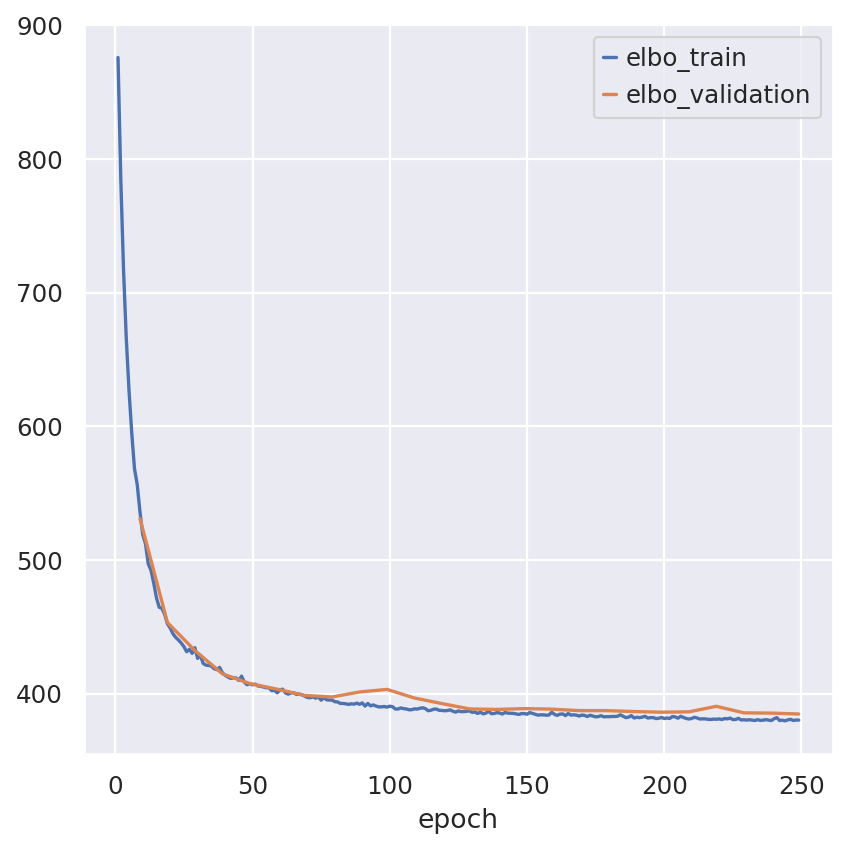

In [9]:
train_elbo = model.history["elbo_train"][1:]
test_elbo = model.history["elbo_validation"]

ax = train_elbo.plot()
test_elbo.plot(ax=ax)

## Extract and plot latent dimensions for cells

From the fitted model we extract the (mean) values for the latent dimensions. We store the values in the AnnData object for convenience.

In [10]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f"Z_{i}"] = z

Now we can plot the latent dimension coordinates for each cell. A quick (albeit not complete) way to view these is to make a series of 2D scatter plots that cover all the dimensions. Since we are representing the cells by 10 dimensions, this leads to 5 scatter plots.

/tmp/ipykernel_158/650095484.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgd.legendHandles:


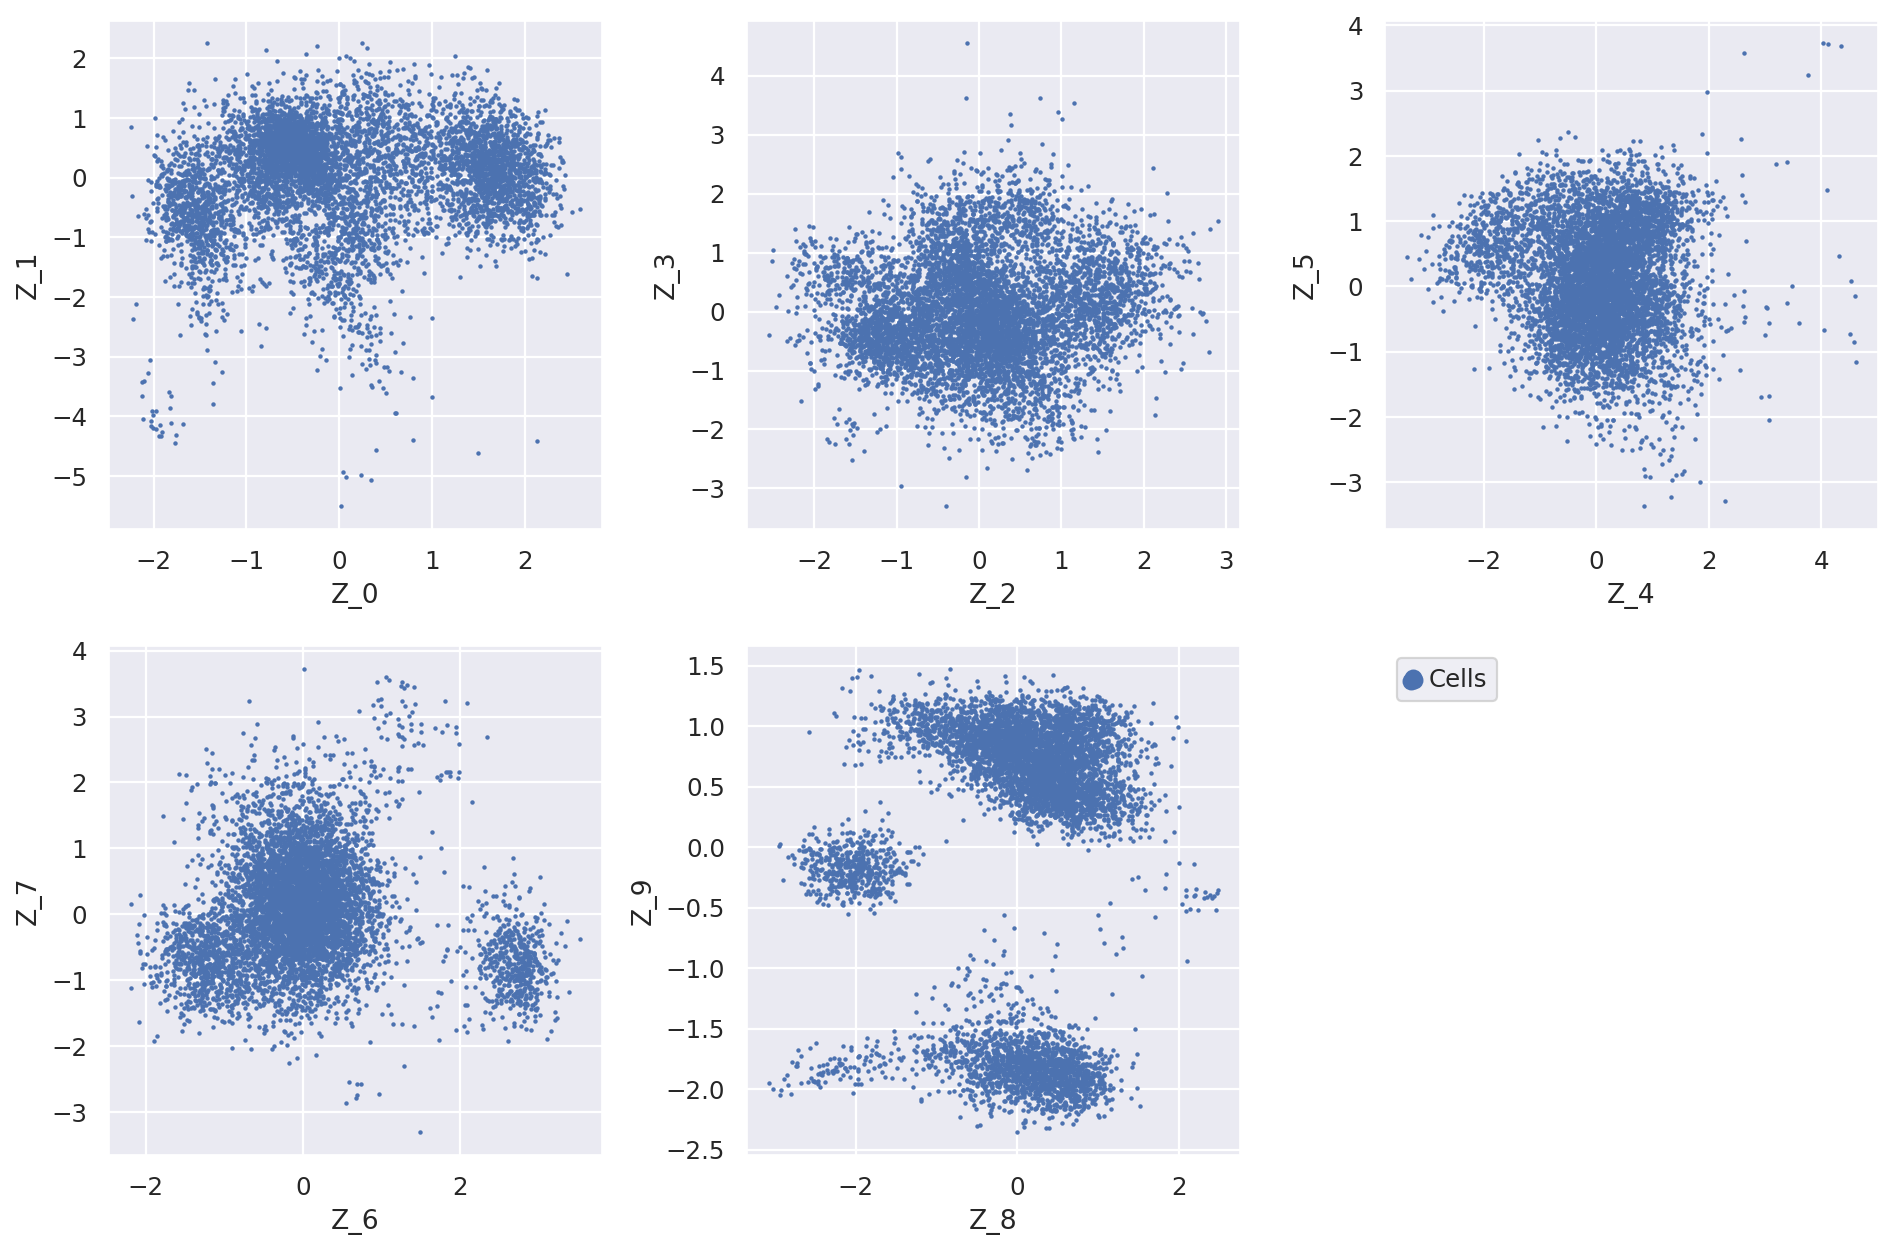

In [11]:
fig = plt.figure(figsize=(12, 8))

for f in range(0, 9, 2):
    plt.subplot(2, 3, int(f / 2) + 1)

    plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", s=4, label="Cells")

    plt.xlabel(f"Z_{f}")
    plt.ylabel(f"Z_{f + 1}")

plt.subplot(2, 3, 6)
plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", label="Cells", s=4)
plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], c="w", label=None)
plt.gca().set_frame_on(False)
plt.gca().axis("off")

lgd = plt.legend(scatterpoints=3, loc="upper left")
for handle in lgd.legend_handles:
    handle.set_sizes([200])


plt.tight_layout()

The question now is how does the latent dimensions link to genes?

For a given cell x, the expression of the gene g is proportional to x_g = w\_(1, g) * z_1 + ... + w\_(10, g) * z_10. Moving from low values to high values in z_1 will mostly affect expression of genes with large w\_(1, :) weights. We can extract these weights from the `LDVAE` model, and identify which genes have high weights for each latent dimension.

In [12]:
loadings = model.get_loadings()
loadings.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9
index,,,,,,,,,,
AL645608.8,0.756368,-0.100683,0.252074,0.032404,-0.320864,-0.224881,-0.577871,-0.506318,-0.081928,-0.094992
HES4,0.830323,-0.164451,0.253209,-0.442601,-0.400809,0.151515,-0.316611,-0.217516,-0.282952,-0.228449
ISG15,0.446458,0.214321,0.270536,-0.326161,0.047629,-0.221070,-0.220856,-0.124097,0.036333,0.647635
TNFRSF18,-0.302383,0.107218,1.281761,-0.547311,-0.042539,-0.420978,0.295821,-0.471220,0.176347,2.154885
TNFRSF4,0.290854,0.373043,1.157335,-0.623632,0.037839,-0.663865,0.086800,-0.213453,0.248516,1.954238


For every latent variable Z, we extract the genes with largest _magnitude_, and separate genes with large negative values from genes with large positive values. We print out the top 5 genes in each direction for each latent variable.

In [13]:
print(
    "Top loadings by magnitude\n------------------------------------------------------------------"
    "---------------------"
)
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ":\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.head(5).index])
    fstr += "\n\t...\n\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.tail(5).index])
    print(
        fstr
        + "\n-------------------------------------------------------------------------------------"
        "--\n"
    )

Top loadings by magnitude
---------------------------------------------------------------------------------------
Z_0:	GNLY, -0.95	LMNA, -0.87	CES1, -0.85	CCL4L2, -0.84	LINC00996, -0.84
	...
	NELL2, 1.7	LEF1, 1.8	TSHZ2, 1.9	CCR7, 2.1	LRRN3, 2.4
---------------------------------------------------------------------------------------

Z_1:	CDC20, -0.73	MYBL2, -0.71	PLD4, -0.7	TYMS, -0.7	IGLL5, -0.68
	...
	NRG1, 1.4	FOXP3, 1.4	ALDH1A1, 1.4	PMCH, 1.4	ARG1, 1.5
---------------------------------------------------------------------------------------

Z_2:	HBA1, -1.1	CD160, -0.99	TCL1B, -0.95	TCL1A, -0.88	AL139020.1, -0.83
	...
	C19ORF33, 1.2	TNFRSF18, 1.3	COL5A3, 1.4	LMNA, 1.8	IFI27, 1.8
---------------------------------------------------------------------------------------

Z_3:	FPR3, -1.7	C1QA, -1.6	TRDC, -1.6	C1QB, -1.4	XCL1, -1.4
	...
	SSPN, 0.91	IGLV6-57, 0.97	IGLV1-51, 0.99	COCH, 1.0	SHISA8, 1.0
---------------------------------------------------------------------------------------

Z_4:

It is important to keep in mind that unlike traditional PCA, these latent variables are not ordered. Z_0 does not necessarily explain more variance than Z_1.

These top genes can be interpreted as following most of the structural variation in the data.

The `LinearSCVI` model further supports the same scVI functionality as the `SCVI` model, so all posterior methods work the same. Here we show how to use scanpy to visualize the latent space.

In [14]:
SCVI_LATENT_KEY = "X_scVI"
SCVI_CLUSTERS_KEY = "leiden_scVI"

adata.obsm[SCVI_LATENT_KEY] = Z_hat
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.8)

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


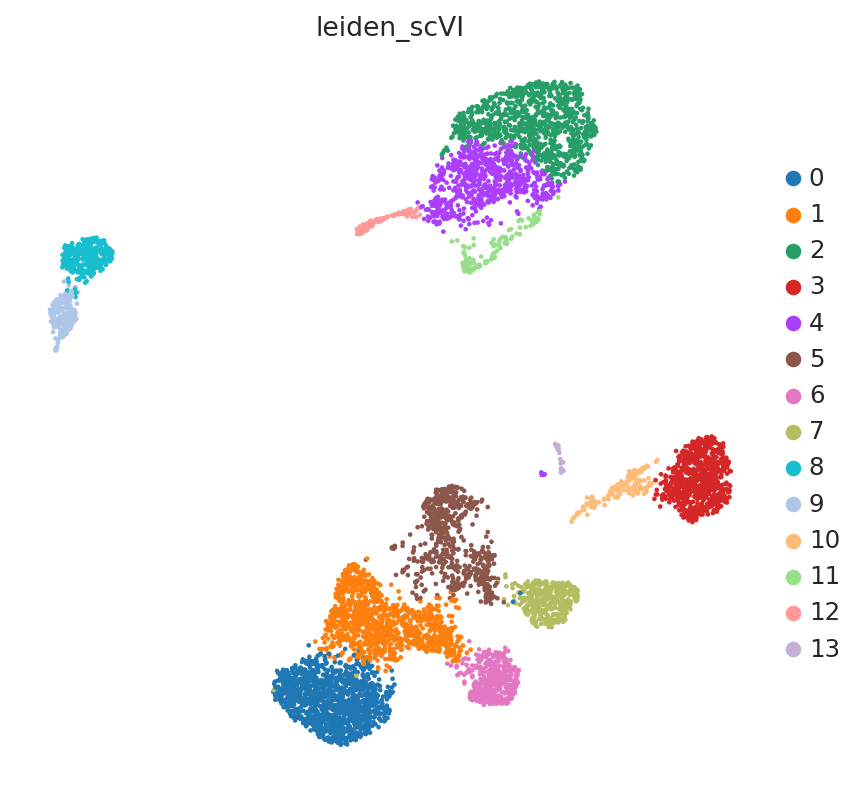

In [15]:
sc.pl.umap(adata, color=[SCVI_CLUSTERS_KEY])

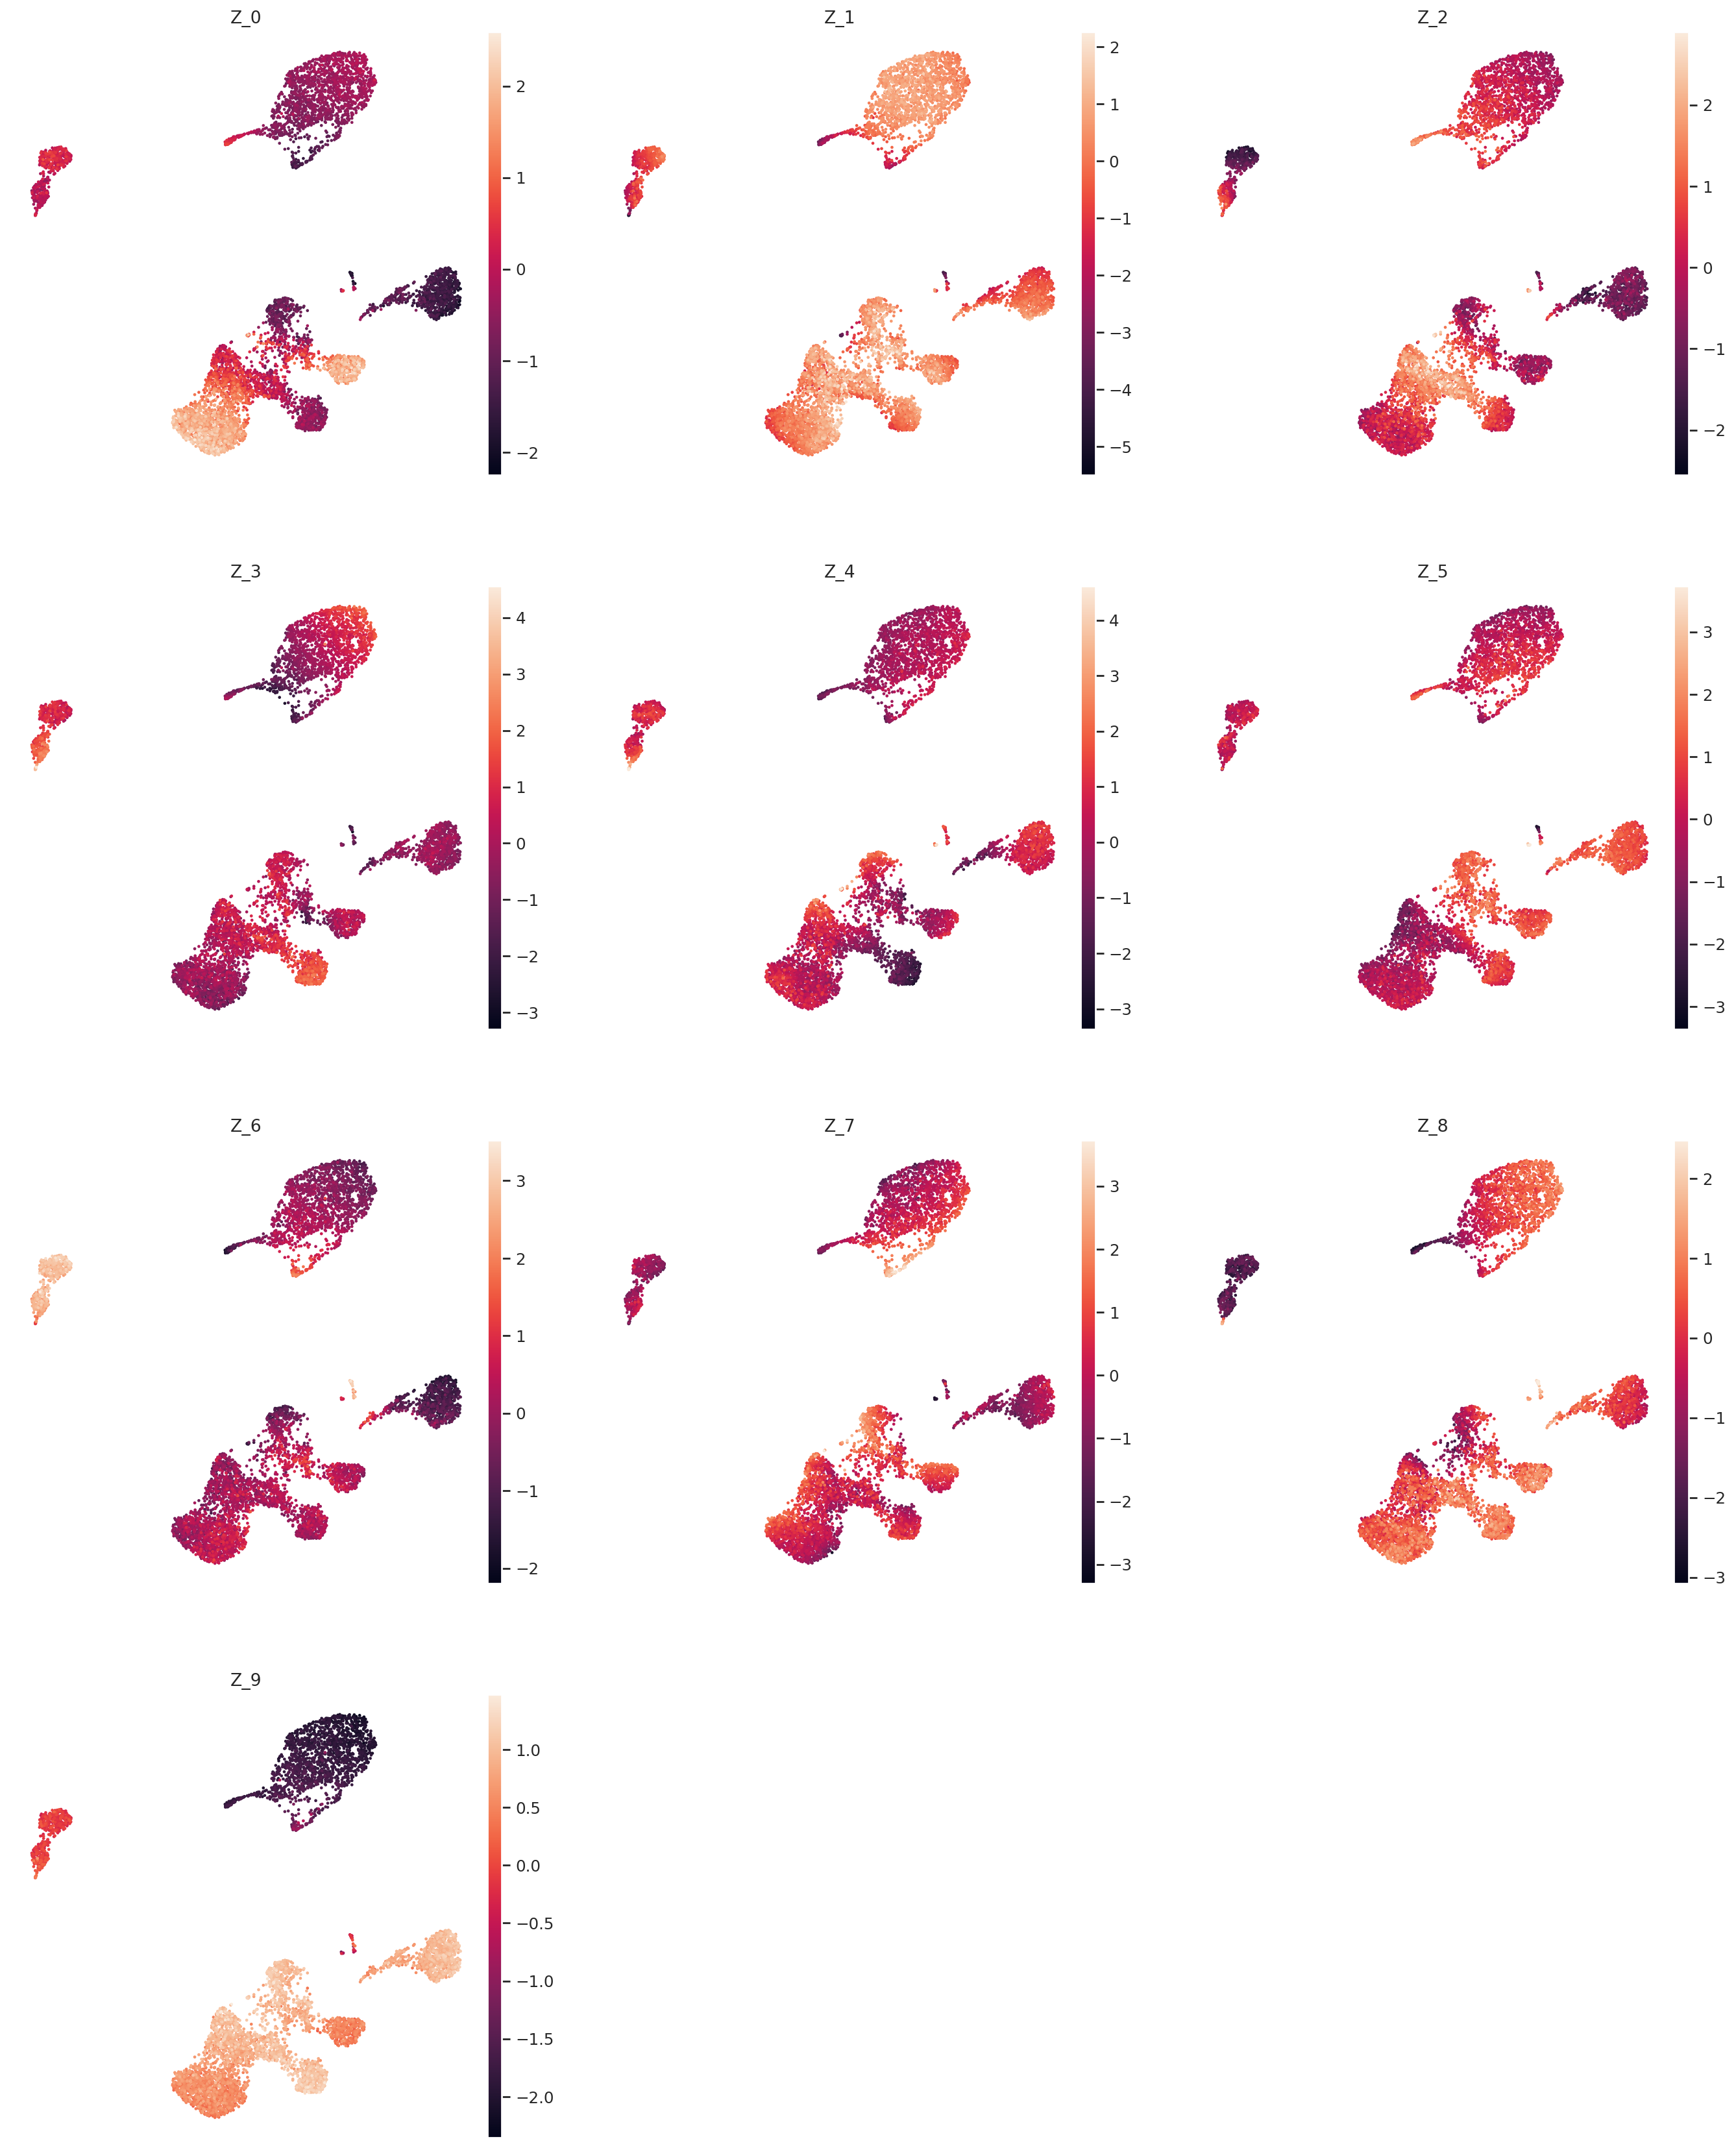

In [16]:
zs = [f"Z_{i}" for i in range(model.n_latent)]
sc.pl.umap(adata, color=zs, ncols=3)